# Assignment - Advanced Regression


A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price.

Build A regression model using regularization to in order to predict the actual value of the prospective properties in Australia and this helps the company to decide whether to invest in them or not.

The company wants to know:

1. Which variables are significant in predicting the price of a house ? and

2. How well those variables describe the price of a house ?

3. Determine the optimal value of lambda for ridge and lasso regression.

_Student: SM Arun Kumar_<br>
_Batch: IIIT-Bangalore AI& ML - Jan 2024_ 

In [1]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler,scale,LabelEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.feature_selection import RFE

import statsmodels.api as sm 
from  statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the file
house = pd.read_csv('train.csv')
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

# 1.  Exploratory Data Analysis

In [3]:
#shape of the raw dataset
house.shape

(1460, 81)

In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## A. Data Cleaning

### Checking for not available data

__Note: Most of the cells having NA is not due to unavailability of data rather those perticular features are not present in the property__

In [5]:
# Percentage of NA values in the following features
#Note: Since csv field is filled with NA, pandas treat them as Null values, lets check and take appropriate action for each feature
house[house.columns[house.isna().sum()!=0]].isnull().mean()*100

LotFrontage     17.739726
Alley           93.767123
MasVnrType      59.726027
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

In [6]:
#Dropping Pool Quality and it corresponding Pool area as less than 0.5% of properties have this information.
house.PoolQC.value_counts()

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64

In [7]:
house.PoolArea.value_counts()

PoolArea
0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: count, dtype: int64

In [8]:
house[house['PoolArea'] !=0]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
197    198          75       RL        174.0    25419   Pave   NaN      Reg   
810    811          20       RL         78.0    10140   Pave   NaN      Reg   
1170  1171          80       RL         76.0     9880   Pave   NaN      Reg   
1182  1183          60       RL        160.0    15623   Pave   NaN      IR1   
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   
1386  1387          60       RL         80.0    16692   Pave   NaN      IR1   
1423  1424          80       RL          NaN    19690   Pave   NaN      IR1   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
197          Lvl    AllPub  ...      512     Ex  GdPrv         NaN       0   
810          Lvl    AllPub  ...      648     Fa  GdPrv         NaN       0   
1170         Lvl    AllPub  ...      576     Gd  GdPrv         NaN       0   
1182         Lvl    AllPub  ...      555     Ex  MnPrv         NaN       0   
1298         Bnk    AllPub  ...      480     Gd    NaN         NaN       0   
1386         Lvl    AllPub  ...      519     Fa  MnPrv        TenC    2000   
1423         Lvl    AllPub  ...      738     Gd  GdPrv         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
197       3   2006        WD        Abnorml     235000  
810       1   2006        WD         Normal     181000  
1170      7   2008        WD         Normal     171000  
1182      7   2007        WD        Abnorml     745000  
1298      1   2008       New        Partial     160000  
1386      7   2006        WD         Normal     250000  
1423      8   2006        WD         Alloca     274970  

[7 rows x 81 columns]

In [9]:
# MiscFeature: Dropping Miscellaneous feature and its corresponding MiscVal: 96% of properties doesn't have this feature. 
house.MiscFeature.value_counts()

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64

In [10]:
# Fence: Dropping Fence feature: 80% of properties doesn't have fence.
house.Fence.value_counts()

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64

In [11]:
# Alley: Dropping Alley feature: 93% of properties doesn't have Alley access. Also, we have Street information which I feel is sufficient. 
house.Alley.value_counts()

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

In [12]:
#MasVnrType : Droppping Masonry veneer type and its corresponding MasVnrArea : 58% of propperites doesn't have this feature.
house.MasVnrType.value_counts()

MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

In [13]:
# FireplaceQu: Dropping FireplaceQu feature and its corresponding Fireplaces: 47.26% properties doesn't have fireplace.
house.FireplaceQu.value_counts()

FireplaceQu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64

In [14]:
#Dropping above mentioned features including ID as it doesn't add any value in finding the pattern to predict prices.
house.drop(['Id','FireplaceQu','Fireplaces','MasVnrType','MasVnrArea','Alley','Fence','MiscFeature','MiscVal','PoolQC','PoolArea'],axis=1,inplace=True)

In [15]:
#Post dropping house dimension
house.shape

(1460, 70)

In [16]:
house.head()

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0          60       RL         65.0     8450   Pave      Reg         Lvl   
1          20       RL         80.0     9600   Pave      Reg         Lvl   
2          60       RL         68.0    11250   Pave      IR1         Lvl   
3          70       RL         60.0     9550   Pave      IR1         Lvl   
4          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope  ... WoodDeckSF OpenPorchSF EnclosedPorch  \
0    AllPub    Inside       Gtl  ...          0          61             0   
1    AllPub       FR2       Gtl  ...        298           0             0   
2    AllPub    Inside       Gtl  ...          0          42             0   
3    AllPub    Corner       Gtl  ...          0          35           272   
4    AllPub       FR2       Gtl  ...        192          84             0   

  3SsnPorch ScreenPorch  MoSold  YrSold  SaleType  SaleCondition SalePrice  
0         0           0       2    2008        WD         Normal    208500  
1         0           0       5    2007        WD         Normal    181500  
2         0           0       9    2008        WD         Normal    223500  
3         0           0       2    2006        WD        Abnorml    140000  
4         0           0      12    2008        WD         Normal    250000  

[5 rows x 70 columns]

### Data Imputation

In [17]:
# Percentage of Null values in the following features post dropping features with high NA.
house[house.columns[house.isna().sum()!=0]].isnull().mean()*100

#Note: Except LotFrontage - rest of the feature with NA means the perticular feature is not present in the property

LotFrontage     17.739726
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
dtype: float64

In [18]:
#Imputing with the median value : As per Dataset this feature has missing values
house.LotFrontage = house.LotFrontage.fillna(house.LotFrontage.median())
house.Electrical = house.Electrical.fillna(house.Electrical.mode()[0])

In [19]:
# Rest of the features are categorical and NA will be replaced with with appropriate values.
house.BsmtQual = house.BsmtQual.fillna('NoBsmt')
house.BsmtCond = house.BsmtCond.fillna('NoBsmt')
house.BsmtExposure = house.BsmtExposure.fillna('NoBsmt')
house.BsmtFinType1 = house.BsmtFinType1.fillna('NoBsmt')
house.BsmtFinType2 = house.BsmtFinType2.fillna('NoBsmt')

house.GarageType = house.GarageType.fillna('NoGar')
house.GarageFinish = house.GarageFinish.fillna('NoGar')
house.GarageQual = house.GarageQual.fillna('NoGar')
house.GarageCond = house.GarageCond.fillna('NoGar')
#house.GarageYrBlt = house.GarageYrBlt.fillna('NoGarage')

#GarageBuilt Year will not be replace with any value for now. Let see how this can be handled further.

In [20]:
# All the missing values are imputed 
house[house.columns[house.isna().sum()!=0]].isnull().mean()*100

GarageYrBlt    5.547945
dtype: float64

In [21]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 70 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

### Checking the Data types

In [22]:
house.select_dtypes('float').head()

LotFrontage  GarageYrBlt
0         65.0       2003.0
1         80.0       1976.0
2         68.0       2001.0
3         60.0       1998.0
4         84.0       2000.0

In [23]:
#LotFrontage and GarageYrBlt feature is a integer data type but stored as float type. So, converting it into int type.
print(house.LotFrontage.sum())
print(house.GarageYrBlt.sum())

102001.0
2728360.0


In [24]:
#house.GarageYrBlt = house.GarageYrBlt.astype('int64')
house.LotFrontage = house.LotFrontage.astype('int64')

In [25]:
#MSSubClass is categorical data
house.MSSubClass = house.MSSubClass.astype('object')

In [26]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 70 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   int64  
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

1. All the features with Samples having Not Available with NA are replaced with either NoBsmt/NoGar.
2. Features having less no of Samples are removed.
3. LotFrontage was having Null Value and its imputed with average.
4. Data type has been checked.


## B. Data visualization 

### Data visualization of Target Variable

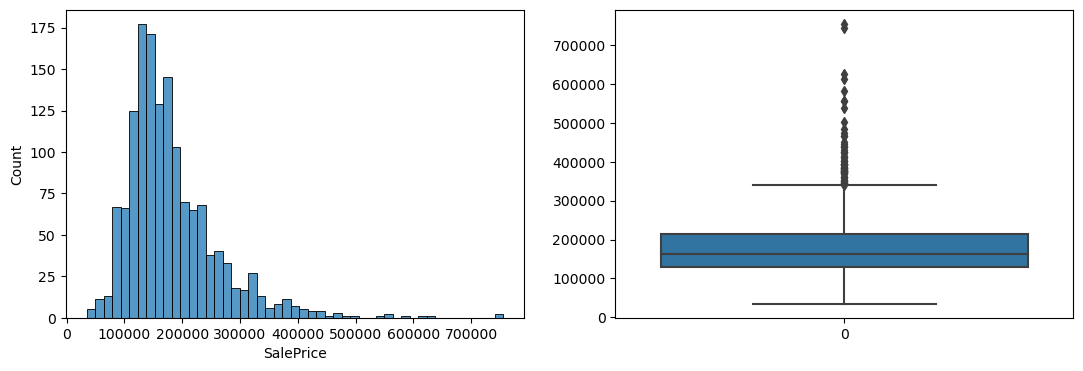

In [27]:
# Distribution of Sales Price
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
sns.histplot(house.SalePrice)
plt.subplot(1,2,2)
sns.boxplot(house.SalePrice)
plt.show()

In [28]:
house.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [29]:
house.SalePrice.quantile([0.10,0.20,0.30,0.5,0.6,0.7,0.75,0.8,0.90,0.91,0.92,0.94,0.95,0.97,0.98,0.99])

0.10    106475.00
0.20    124000.00
0.30    135500.00
0.50    163000.00
0.60    179280.00
0.70    198620.00
0.75    214000.00
0.80    230000.00
0.90    278000.00
0.91    285000.00
0.92    295914.96
0.94    318028.06
0.95    326100.00
0.97    374230.00
0.98    394931.06
0.99    442567.01
Name: SalePrice, dtype: float64

Most of the house prices fall between 100000 to 300000

### Outlier Analysis

Looking at the price vs other variables, we see discontinous range for house prices above 500000 (Price vs Other features can be checked in Data visualization section). Also, the price above 99 quantile is discontinous and exponentially increased. So, excluding the prices above 0.99 quantile.

In [30]:
house = house[house.SalePrice <= 442567]

In [31]:
house.reset_index(drop=True,inplace=True)

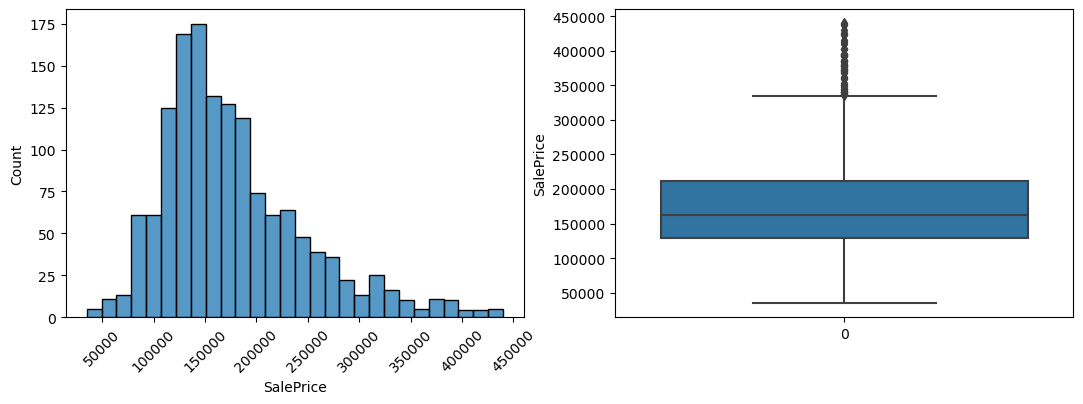

In [32]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
sns.histplot(house.SalePrice)
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.boxplot(house.SalePrice)
plt.ylabel('SalePrice')
plt.show()

Histogram plot shows that target variable is skewed towards right.

### Splitting house data set into Ordinal, Nominal and Continueous data 

In [33]:
#After data cleaning, we have about 70 features.
print('The dataset dimension post data cleaning:',house.shape)
house.dtypes.value_counts()

The dataset dimension post data cleaning: (1445, 70)


object     38
int64      31
float64     1
Name: count, dtype: int64

In [34]:
#Extacting numerical Ordinal features: Needs to be Label Encoded 
houseNumOrdinal = house[['OverallCond','OverallQual','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','GarageCars']]

#Extacting Categorical Ordinal features: Needs to be Order Encoded 
houseCatOrdinal = house[['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','GarageFinish','GarageQual','GarageCond']]


In [35]:
house.select_dtypes(object).columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [36]:
houseNominal = house[house.select_dtypes(object).columns].drop(houseCatOrdinal.columns,axis=1)

In [37]:
house.select_dtypes([int,float]).columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MoSold',
       'YrSold', 'SalePrice'],
      dtype='object')

In [38]:
houseCont = house[house.select_dtypes([int,float]).columns].drop(houseNumOrdinal.columns,axis=1)

In [39]:
houseCont.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MoSold',
       'YrSold', 'SalePrice'],
      dtype='object')

In [40]:
print(houseCatOrdinal.shape)
print(houseNumOrdinal.shape)
print(houseNominal.shape)
print(houseCont.shape)

(1445, 12)
(1445, 10)
(1445, 26)
(1445, 22)


In [41]:
#Readding all the split dataset coulumn should match original house data set column
print(houseCatOrdinal.shape[1]+houseNumOrdinal.shape[1]+houseNominal.shape[1]+houseCont.shape[1])

print(house.shape[1])

70
70


### Data Visualization of Year/Month features

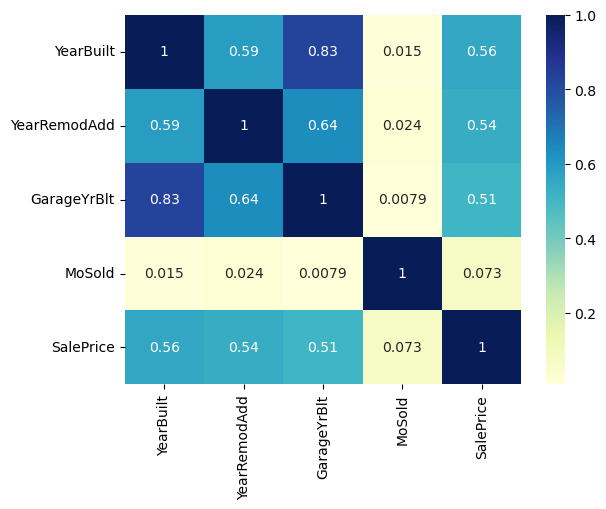

In [42]:
#Visualizing Year/Month features
sns.heatmap(house[['YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','SalePrice']].corr(),annot=True,cmap='YlGnBu')
plt.show()

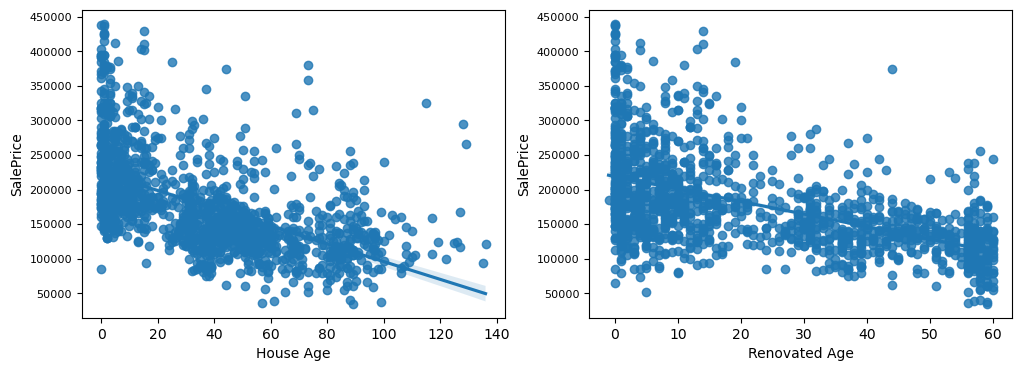

In [43]:
#Derived Metric Age of the House
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
Agehouse = house.YrSold - house.YearBuilt
#plt.figure(figsize=(6,4))
sns.regplot(y=house.SalePrice,x=Agehouse)
plt.yticks(fontsize=8)
plt.xlabel('House Age')
#plt.show()

plt.subplot(1,2,2)
#Derived Metric Renovated Age
Reno = house.YrSold - house.YearRemodAdd
#plt.figure(figsize=(6,4))
sns.regplot(y=house.SalePrice,x=Reno)
plt.yticks(fontsize=8)
plt.xlabel('Renovated Age')
plt.show()

In [44]:
#Adding this Derived Metric to the main house dataset
houseCont['Agehouse'] = Agehouse

In [45]:
# This shows that half of the houses were renovated and above plot shows that older houses being renovated still have a lower price, compared to the newer house that were renovated.
Reno.value_counts().head()

0    117
1     85
4     63
3     53
2     52
Name: count, dtype: int64

1. Older houses are sold for lower prices
2. Houses are sold between the year 2006 and 2010. No pattern observed
3. The above value count 0: 758 indicates that about half of the properties are not renovated.
4. The renovation plot tells that recently renovated house with respect to Year Sold, are sold at higher prices and as the age increaes, prices drop. There is weak negative co-relation.
5. There seems to be some corelation with Age and Renovated plots, so for regression analysis, YearRemodAdd will be removed

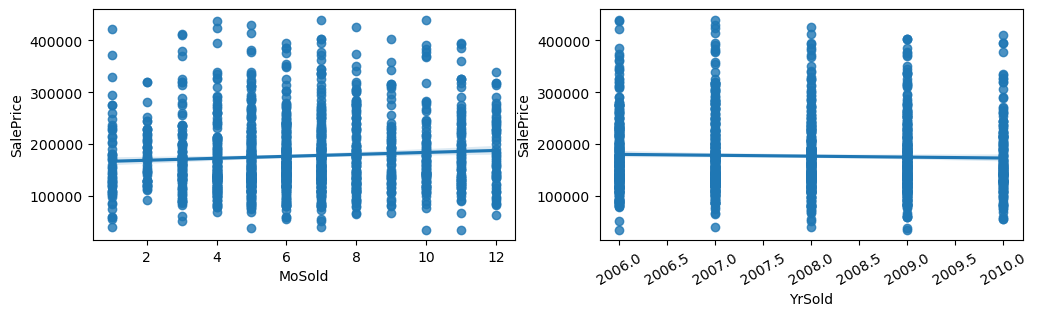

In [46]:
#Property Sold Month
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.regplot(y=house.SalePrice,x=house.MoSold)
plt.subplot(1,2,2)
sns.regplot(y=house.SalePrice,x=house.YrSold)
plt.xticks(rotation=30)
plt.show()

MoSold feature seems to have no correlation with respect to SalePrice. So, this will be removed.

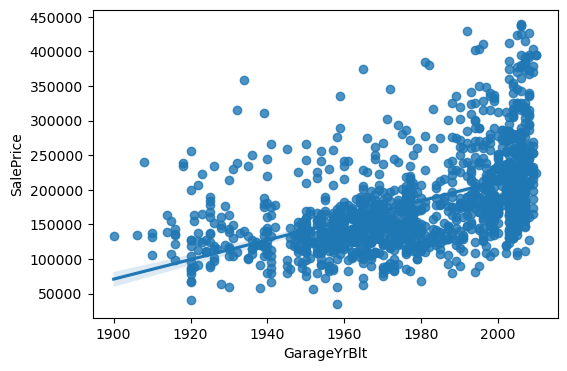

In [47]:
#Garage Year Built
plt.figure(figsize=(6,4))
sns.regplot(y=house.SalePrice,x=house.GarageYrBlt)
plt.show()

Garage year is highly co-related with Year Built. Also, there are other features which are related to Garage. So, this feature will be removed.

In [48]:
houseCont.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold'],axis=1,inplace=True)

__Conclusion from Year Analysis:__
1. Following features are removed YearBuilt, YearRemodAdd, YrSold, MoSold, GarageYrBlt from the house dataset.
2. Derived feature AgeHouse is added to house dataset.

### Data Visualization of other features

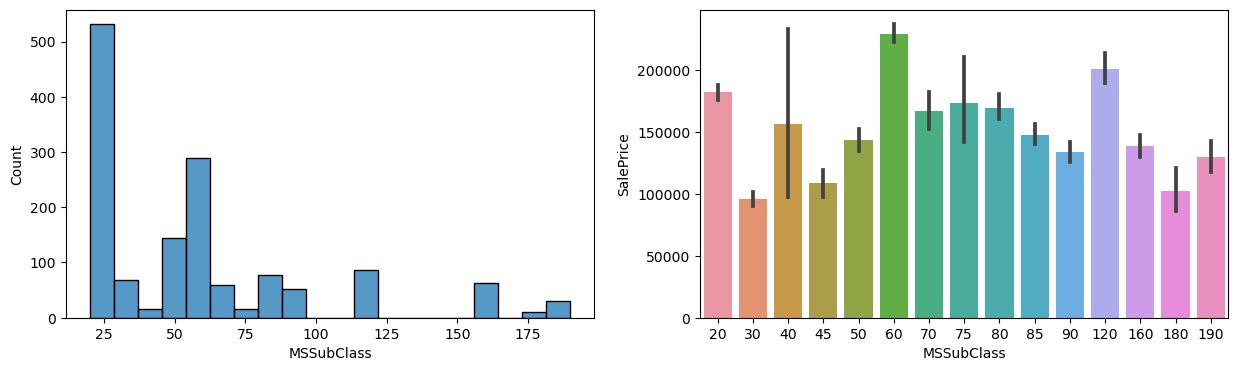

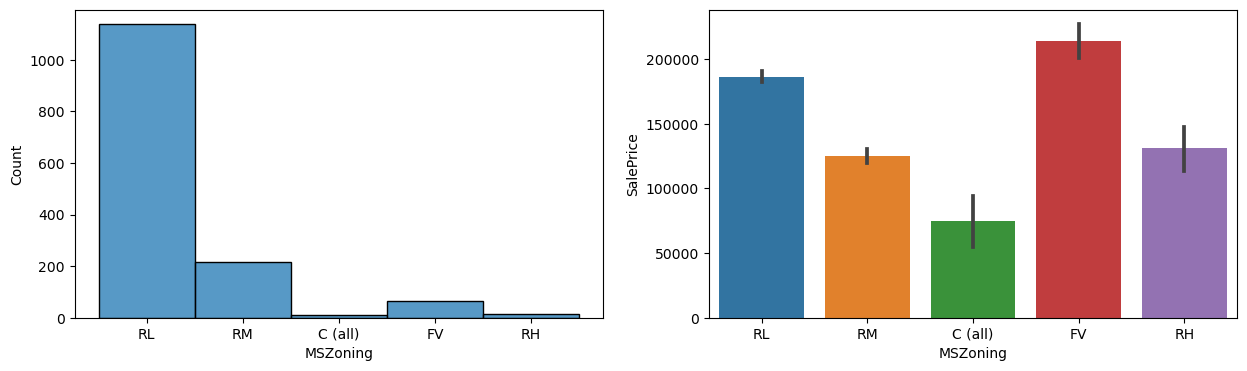

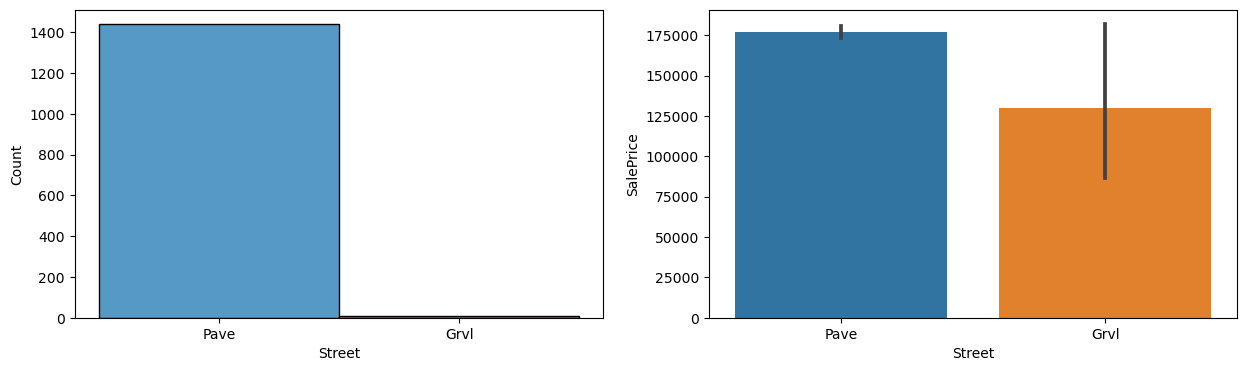

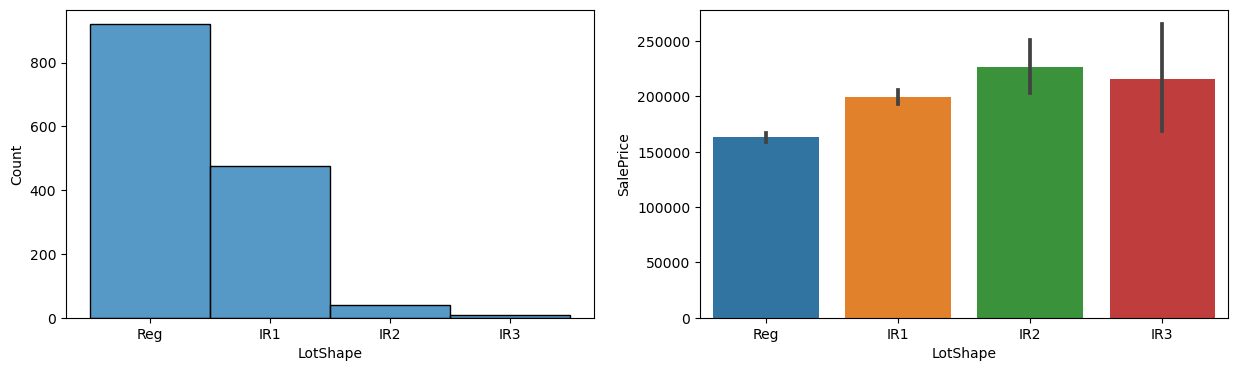

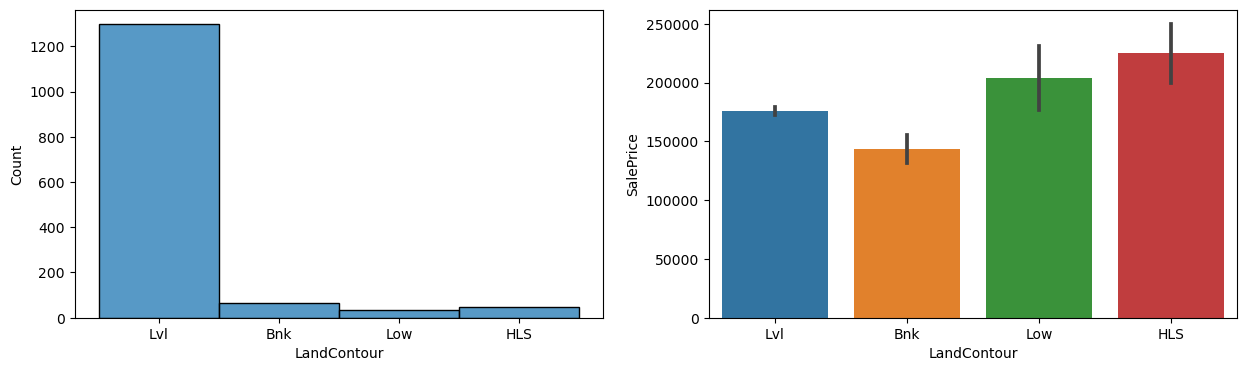

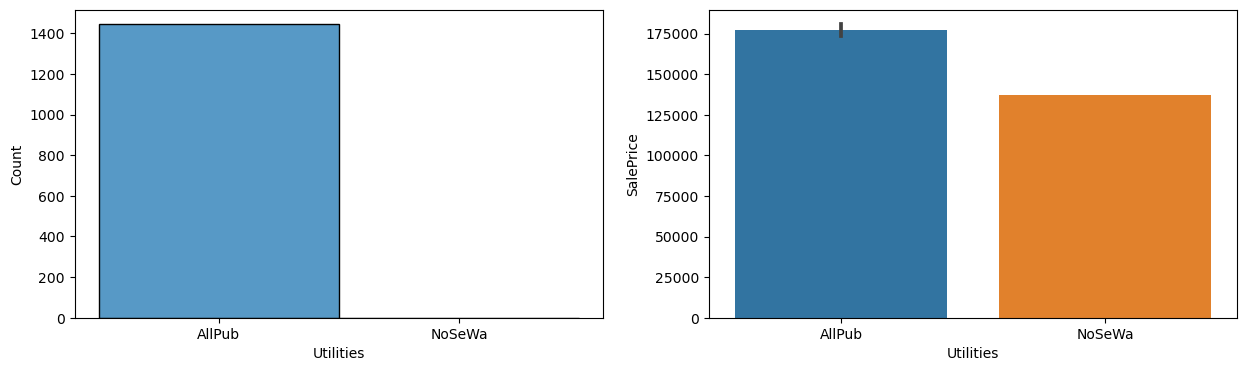

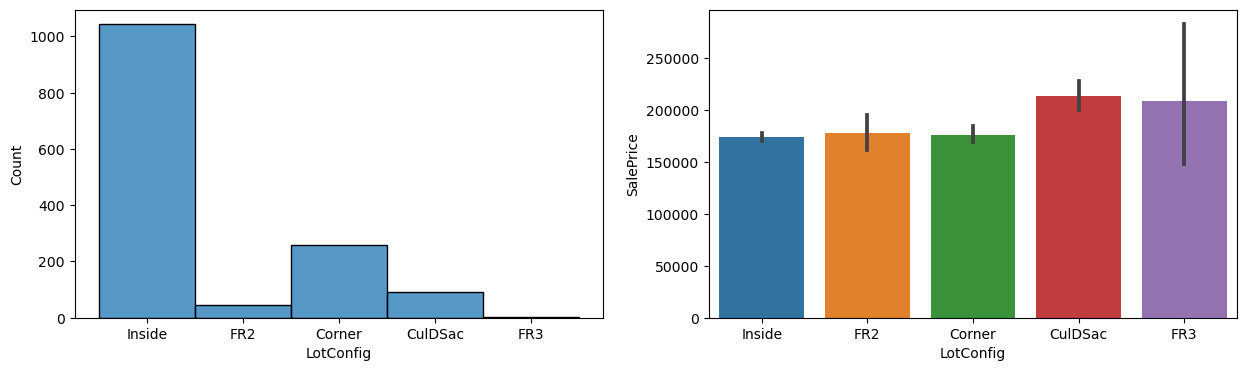

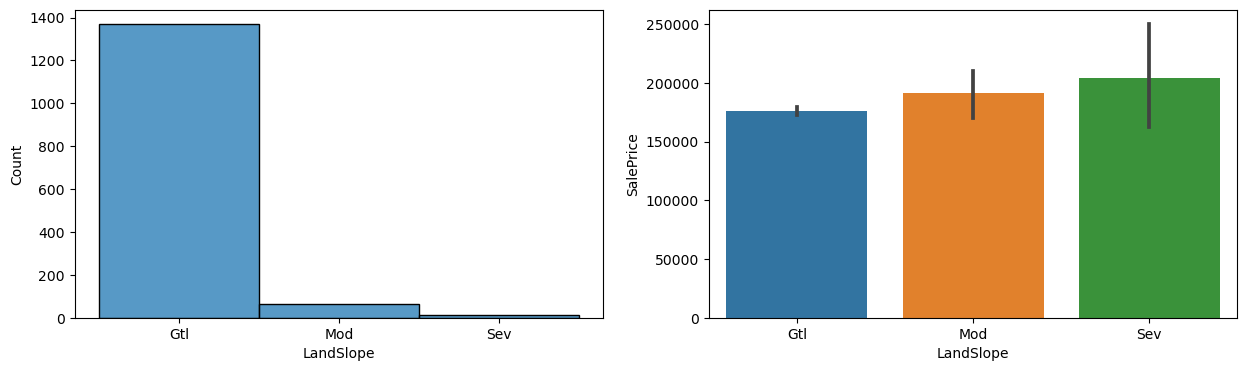

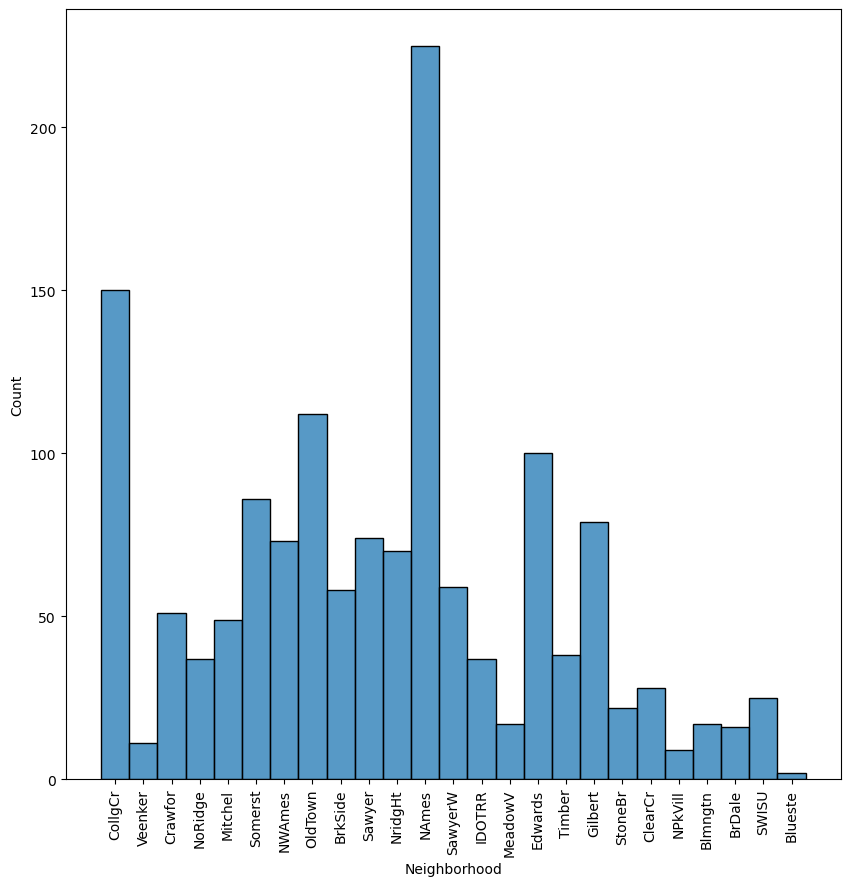

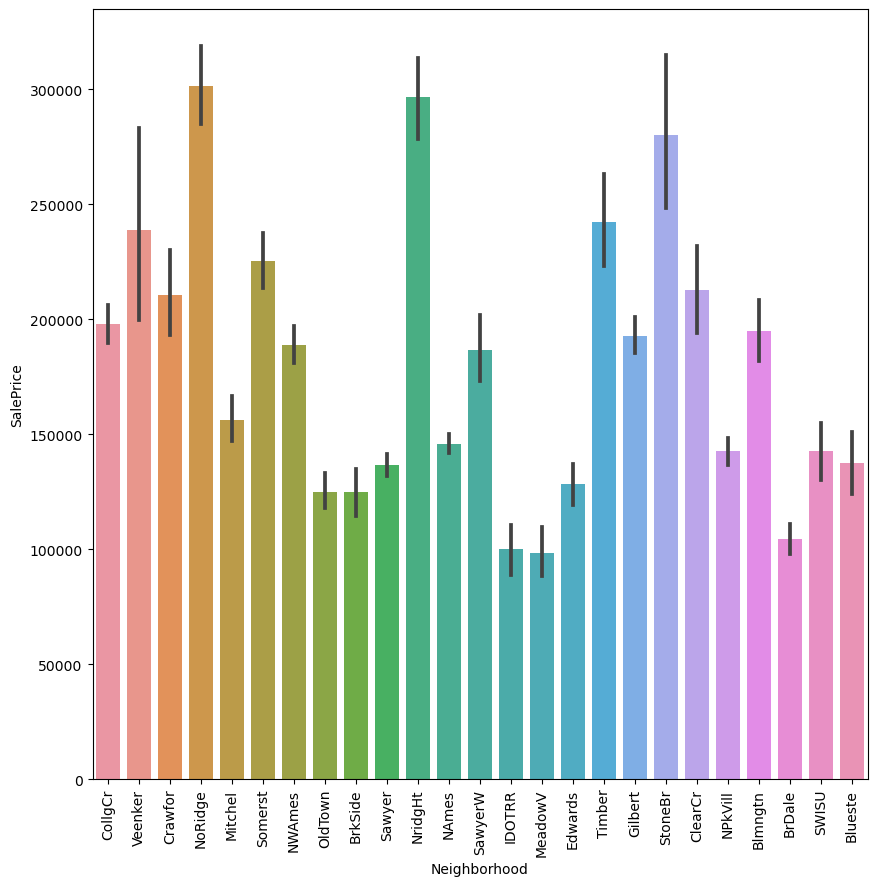

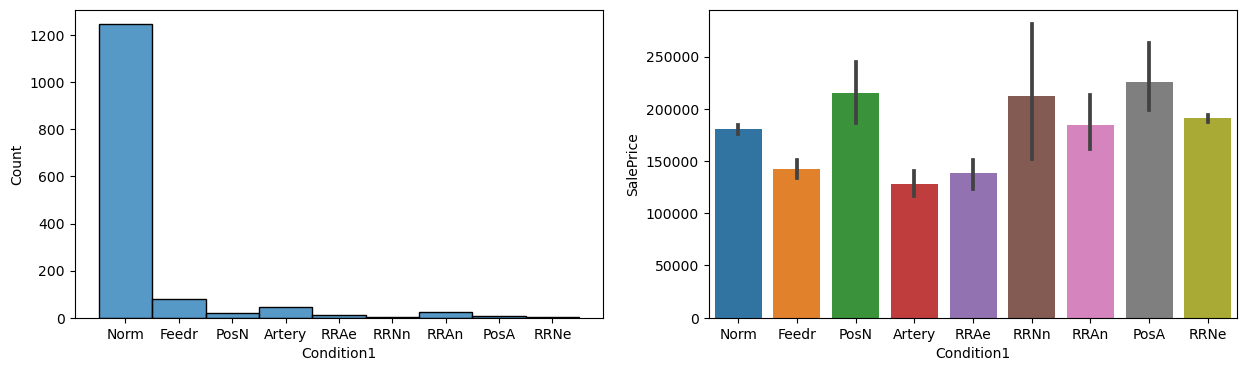

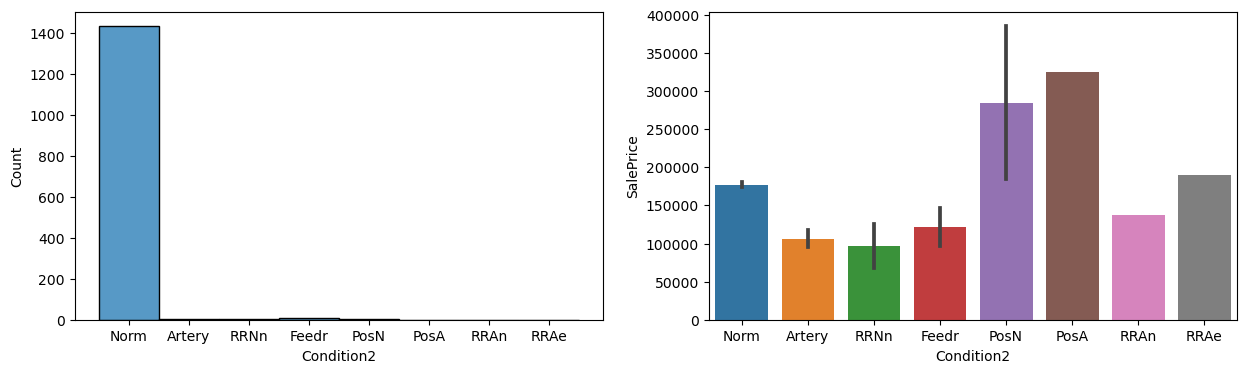

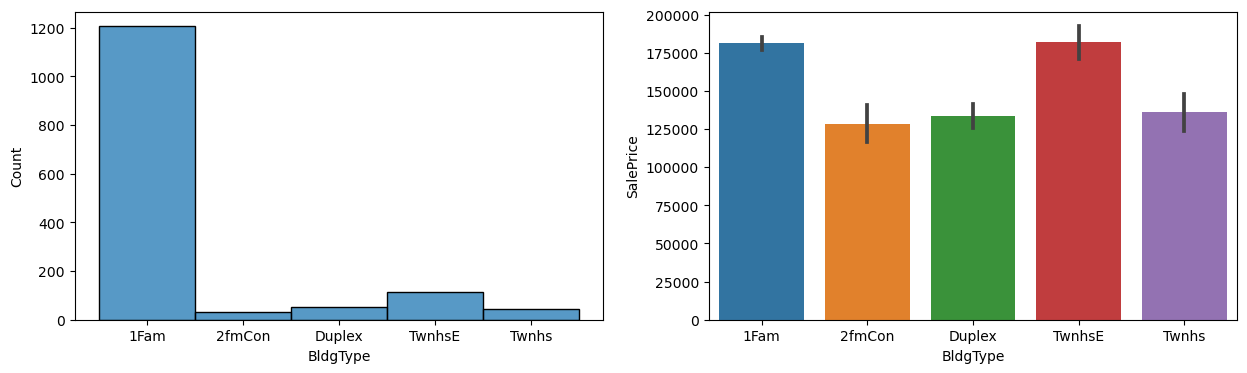

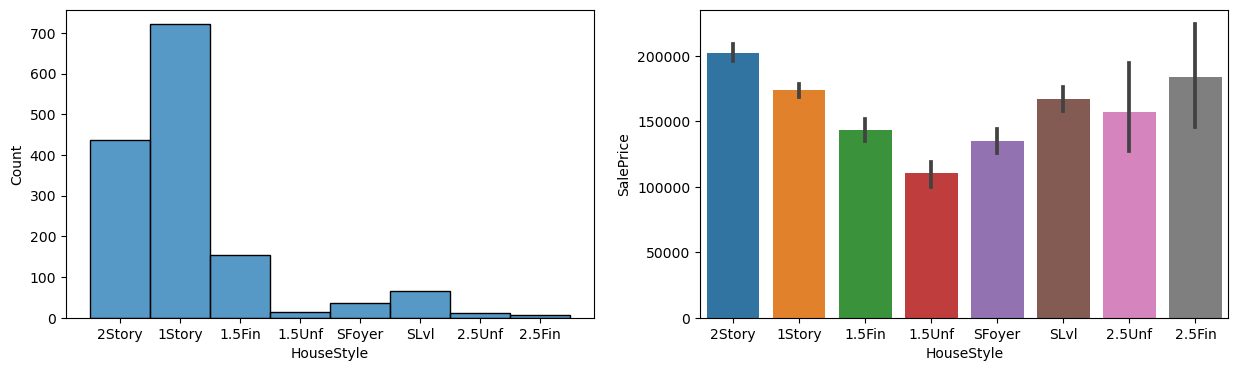

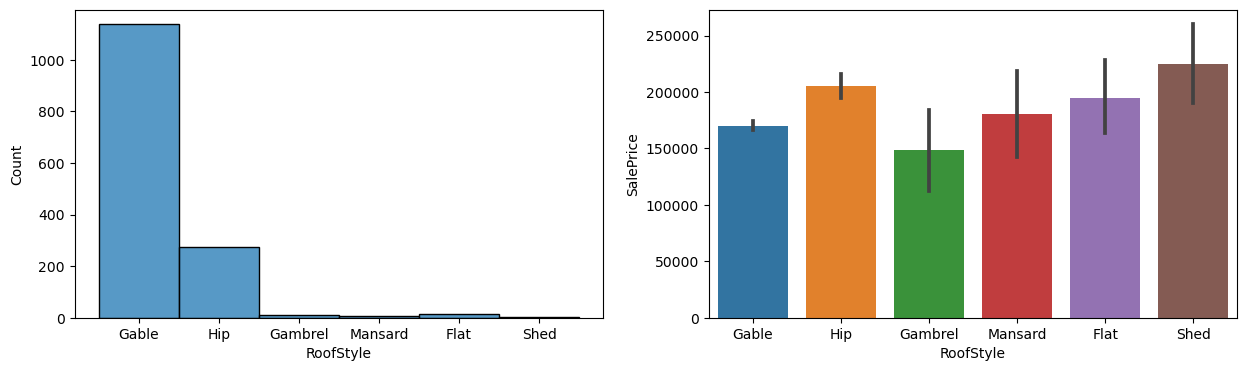

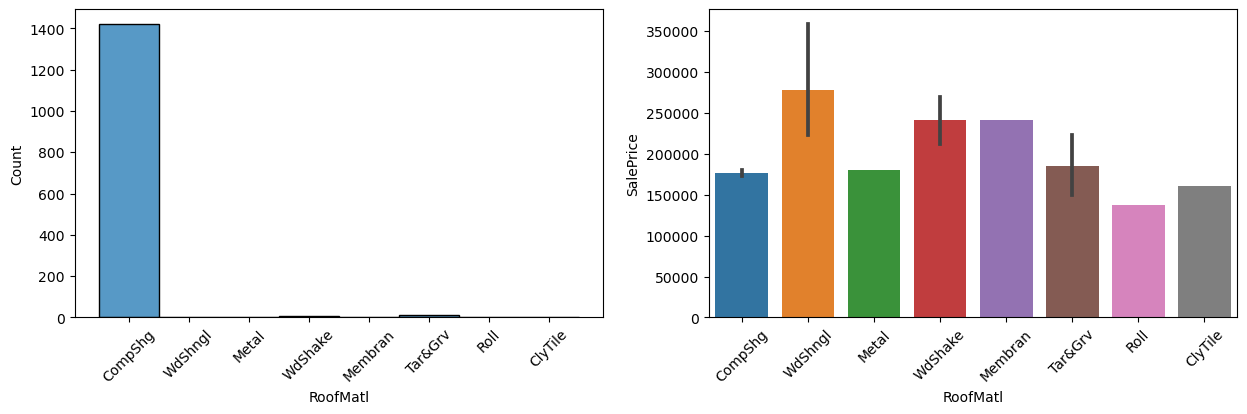

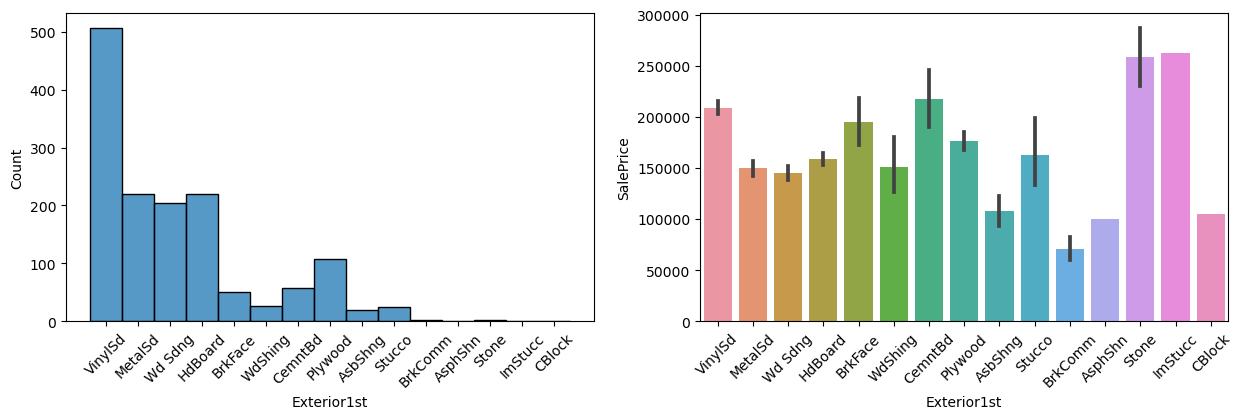

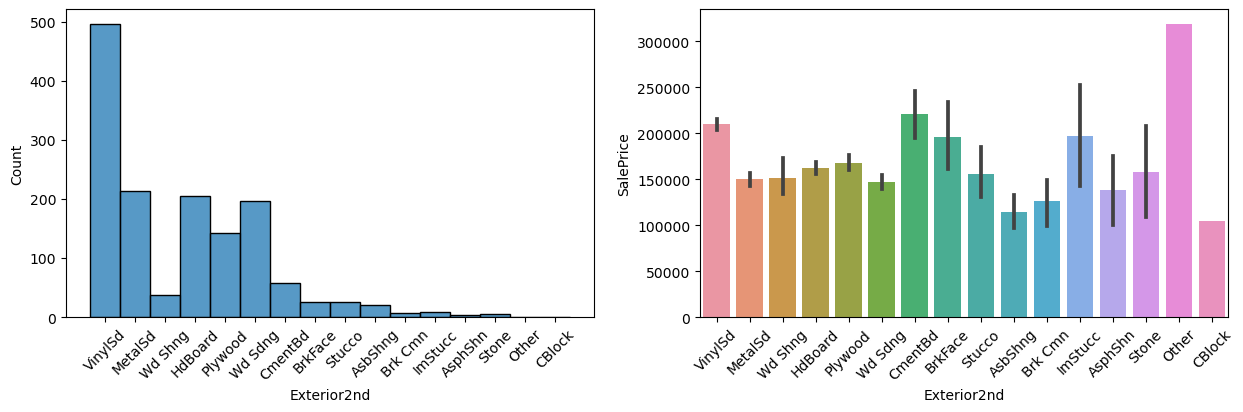

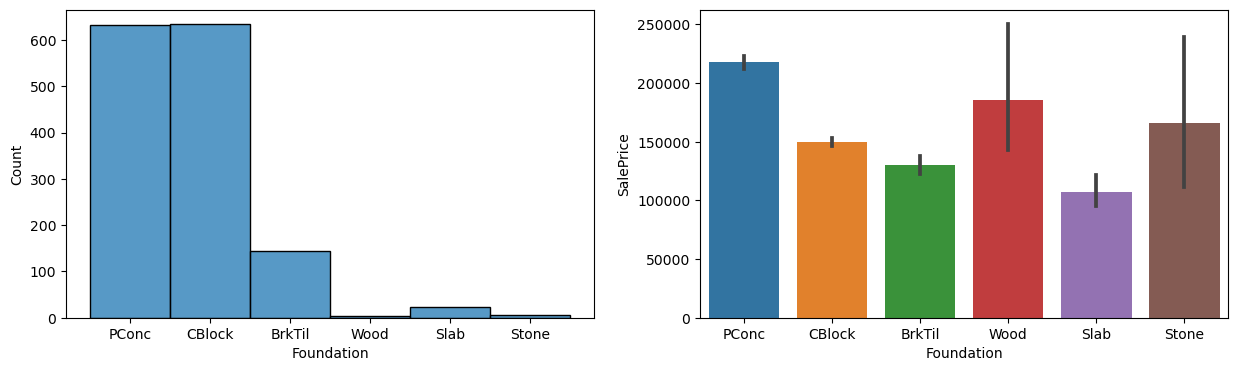

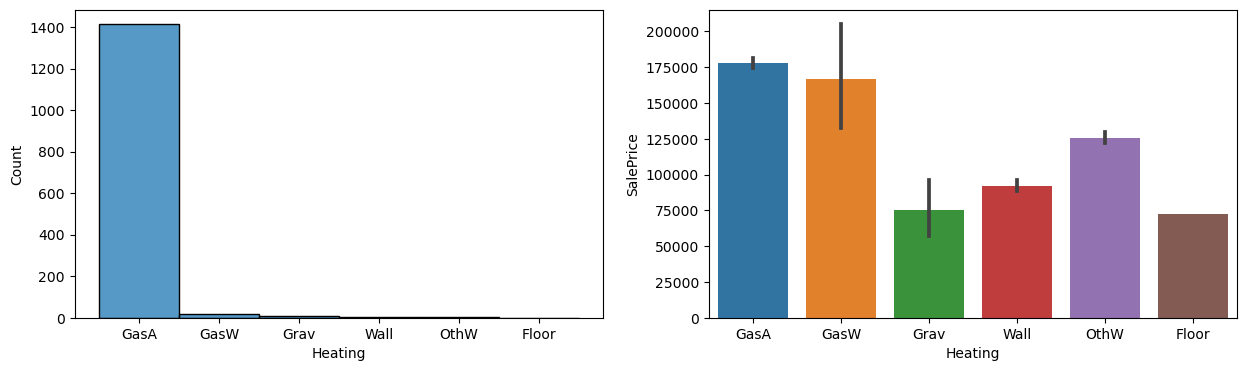

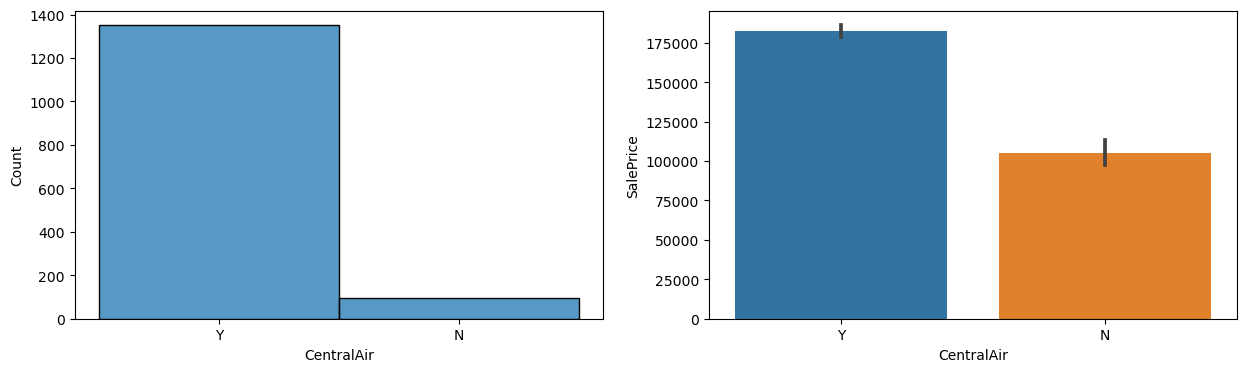

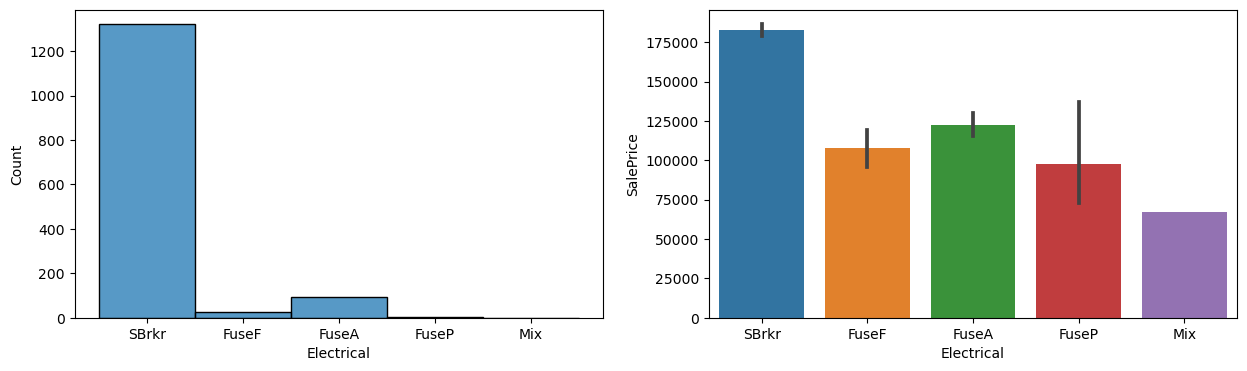

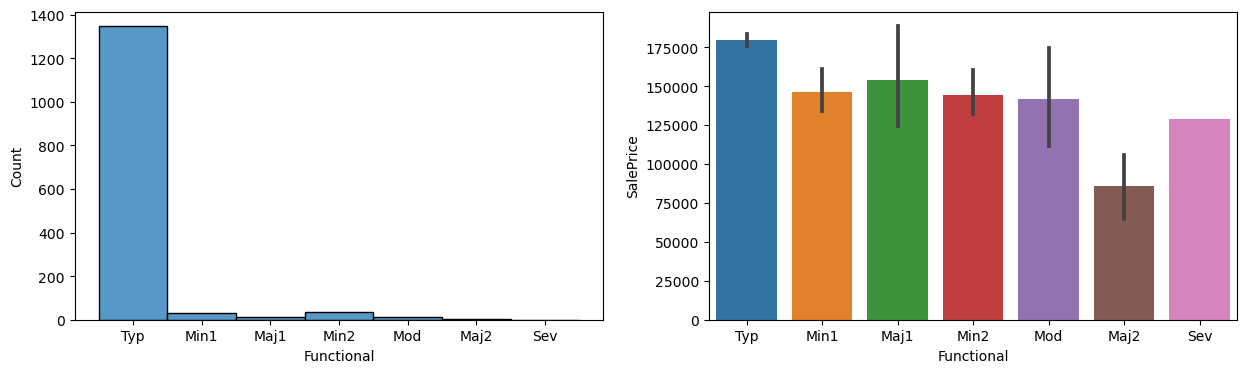

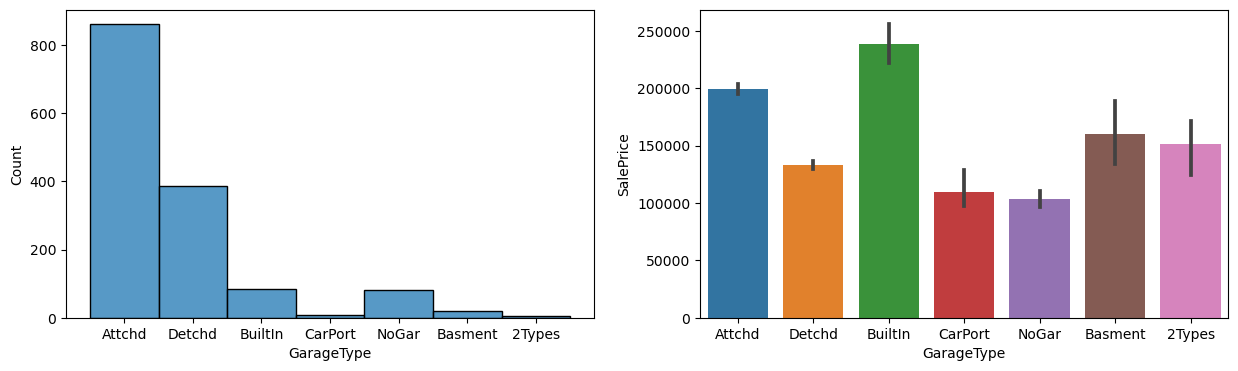

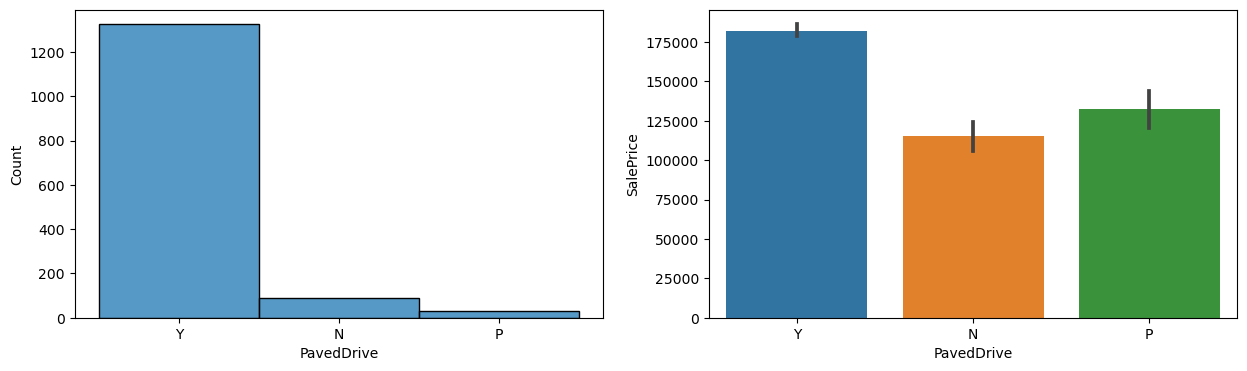

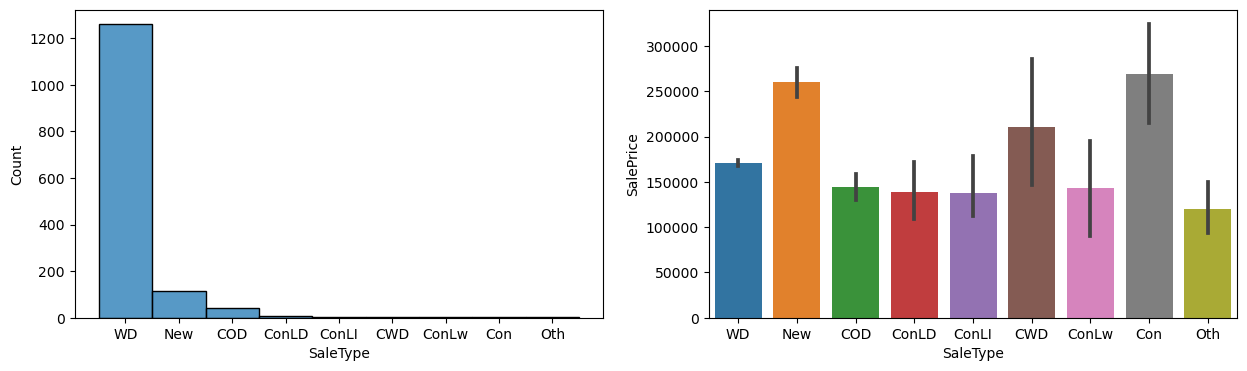

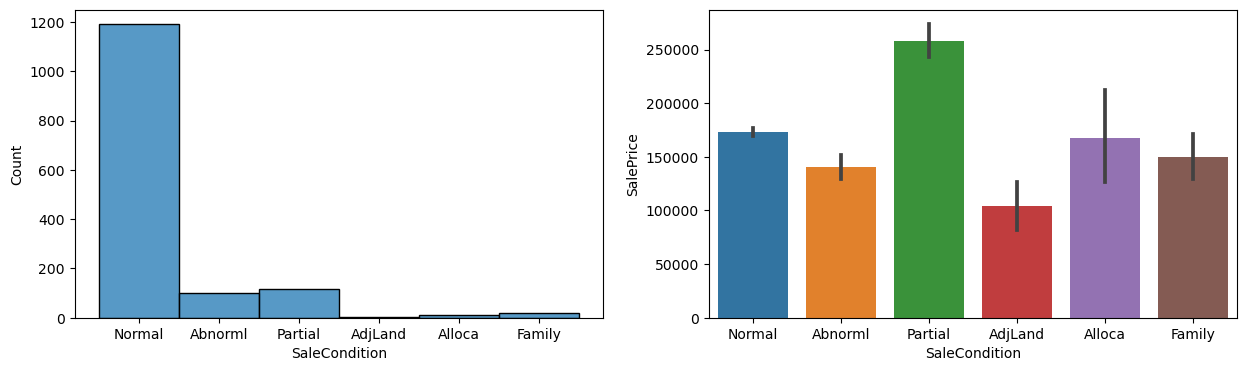

In [49]:
#Univariate Analysis

for i,j in enumerate(houseNominal.columns):
    if j == 'Neighborhood':
        plt.figure(figsize=(10,10))
        plt.subplot(1,1,1)
        sns.histplot(house[j])
        plt.xticks(rotation=90)
        plt.show()
        plt.figure(figsize=(10,10))
        plt.subplot(1,1,1)
        sns.barplot(x=house[j],y=house.SalePrice)
        plt.xticks(rotation=90)
        plt.show()
    elif j == 'RoofMatl' or j == 'Exterior1st' or j == 'Exterior2nd':
        plt.figure(figsize=(15,4))
        plt.subplot(1,2,1)
        sns.histplot(house[j])
        plt.xticks(rotation=45)
        plt.subplot(1,2,2)
        sns.barplot(x=house[j],y=house.SalePrice)
        plt.xticks(rotation=45)
        plt.show()
    else:
        plt.figure(figsize=(15,4))
        plt.subplot(1,2,1)
        sns.histplot(house[j])
        plt.subplot(1,2,2)
        sns.barplot(x=house[j],y=house.SalePrice)
        plt.show()
#sns.histplot(house.Street)

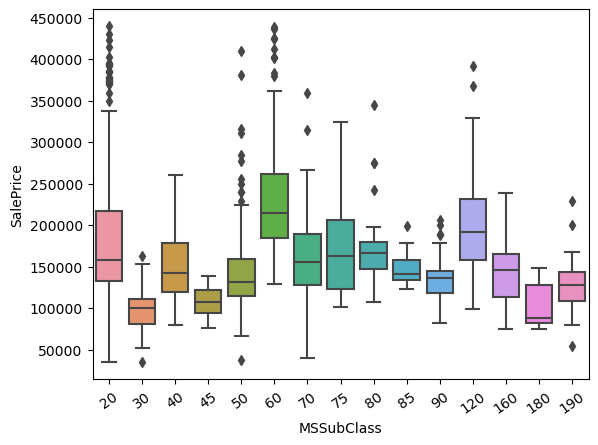

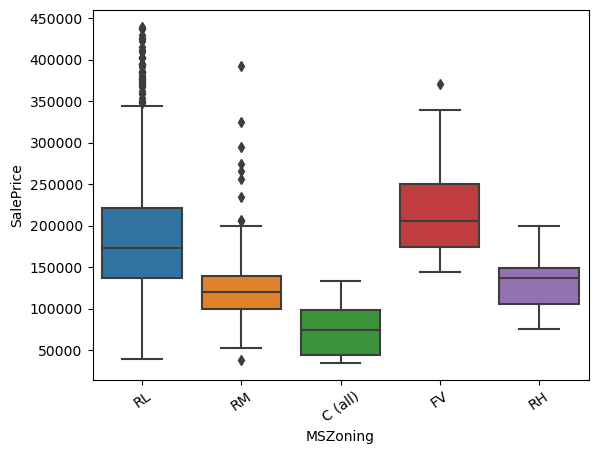

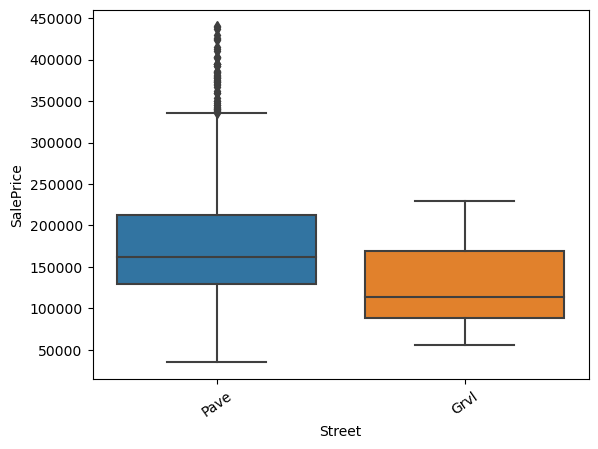

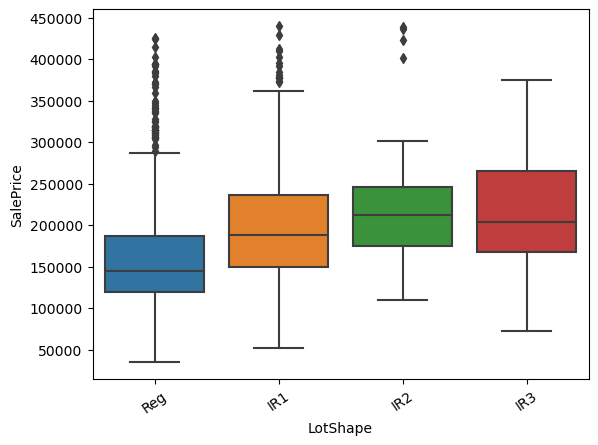

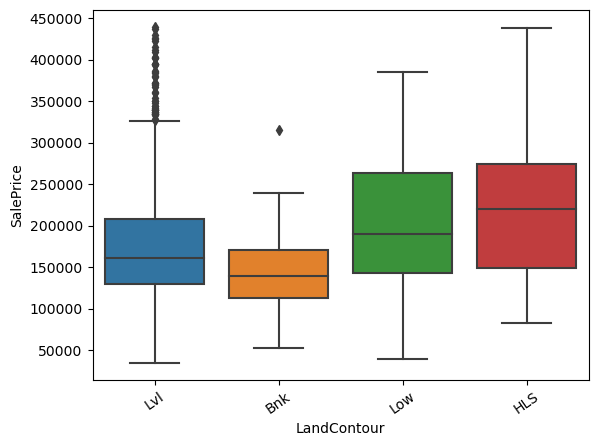

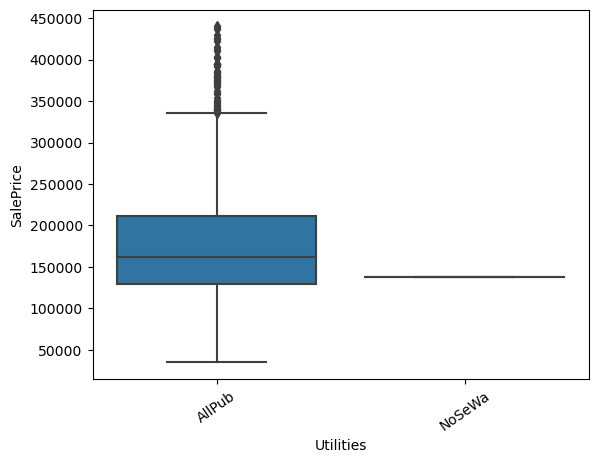

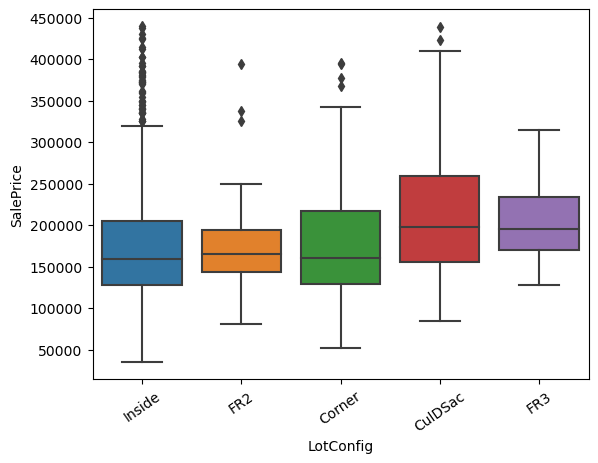

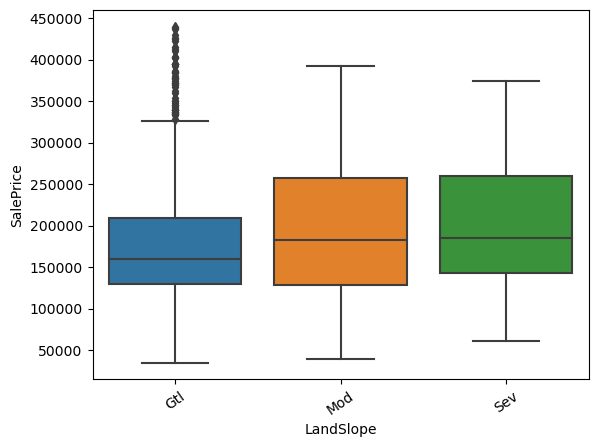

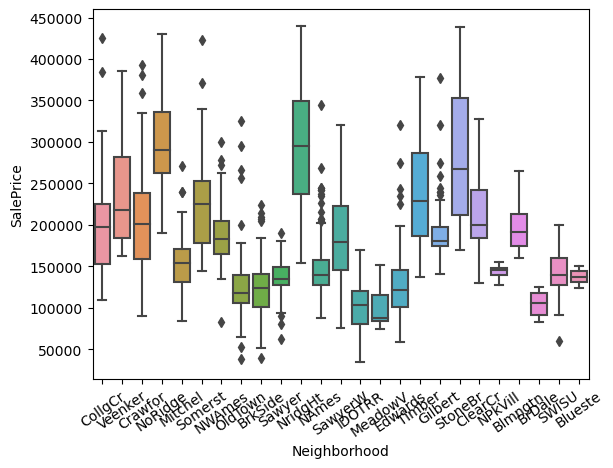

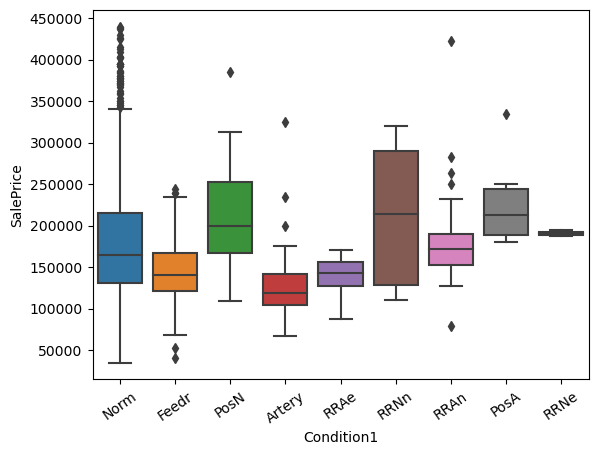

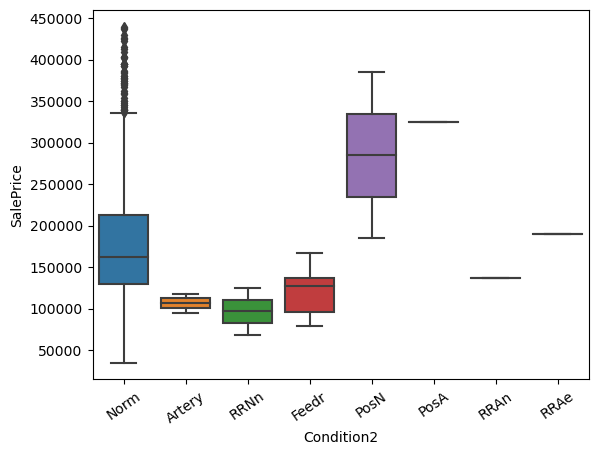

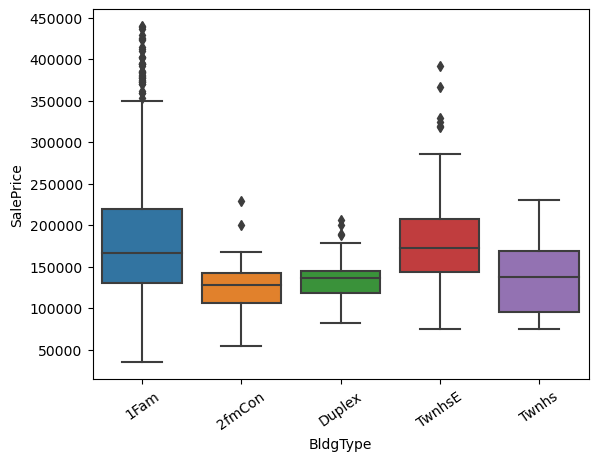

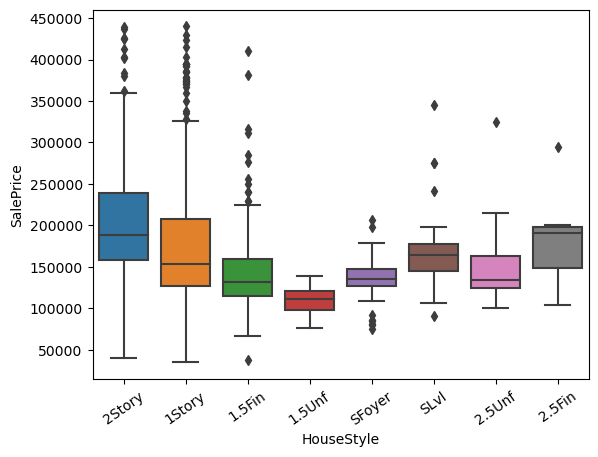

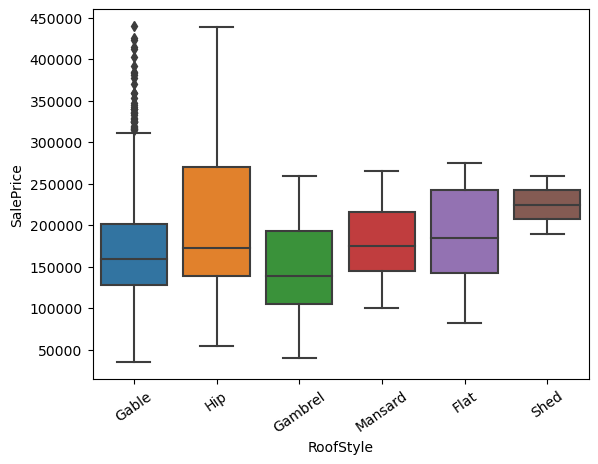

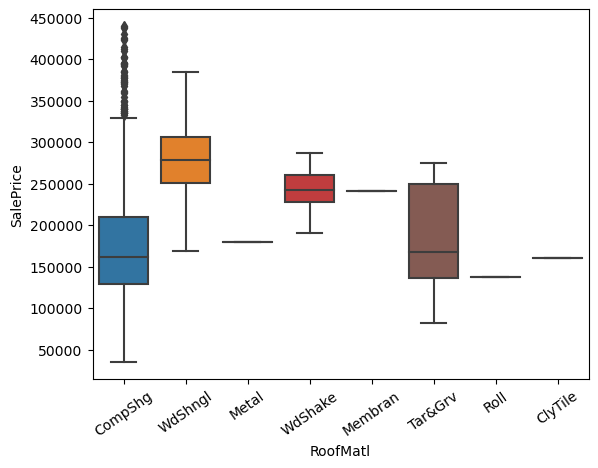

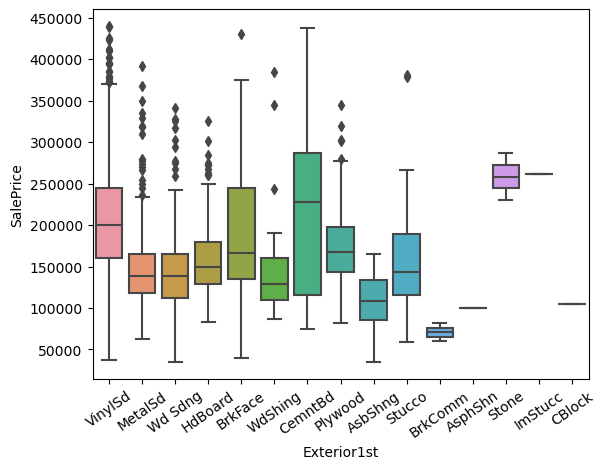

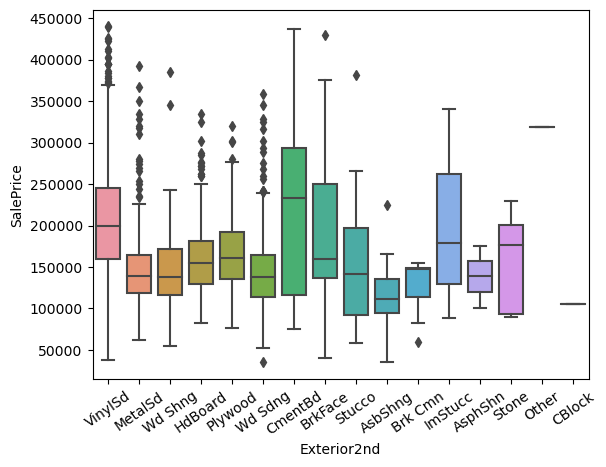

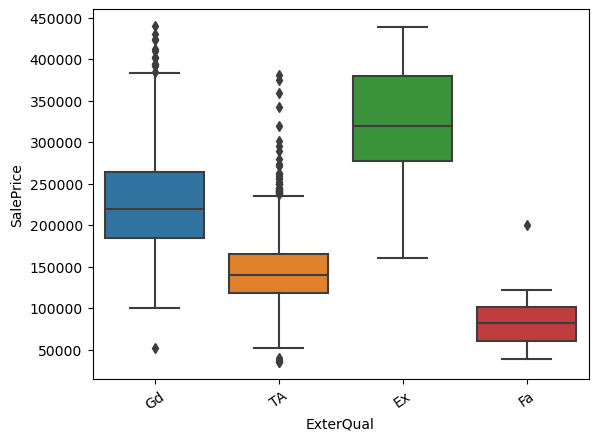

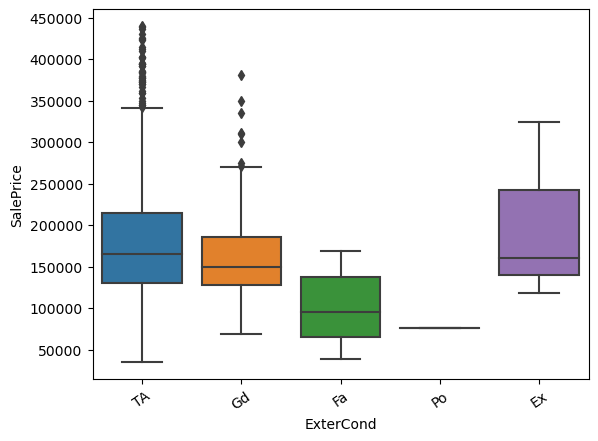

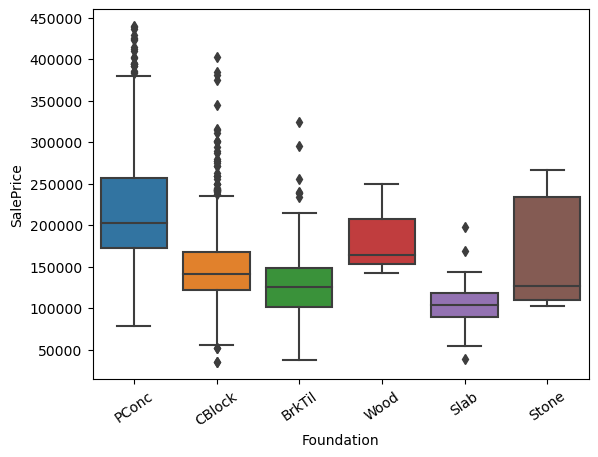

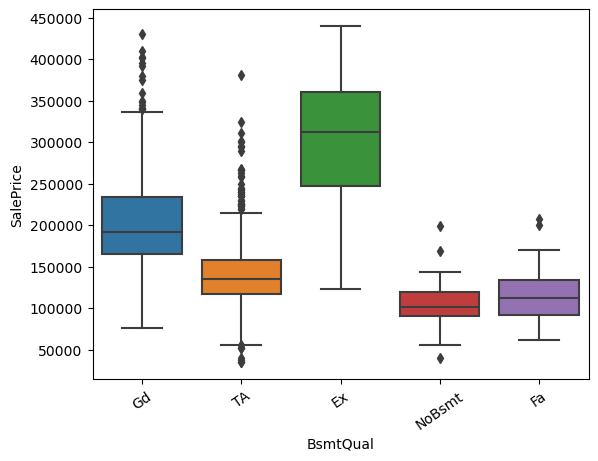

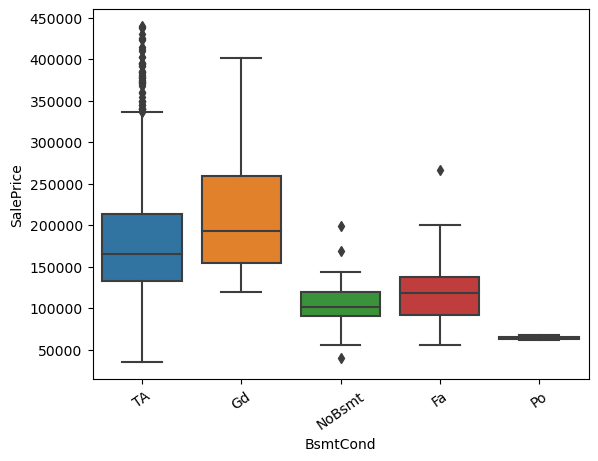

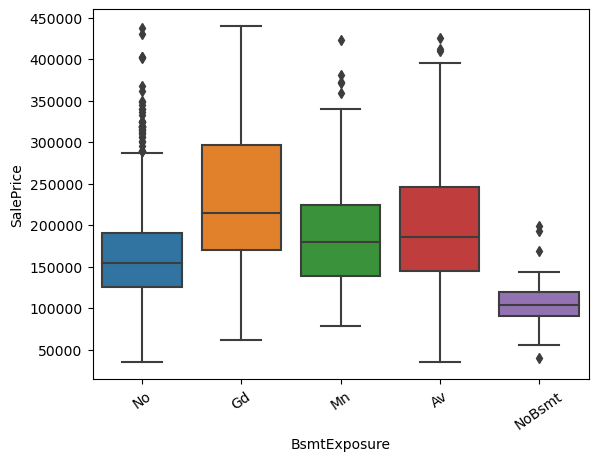

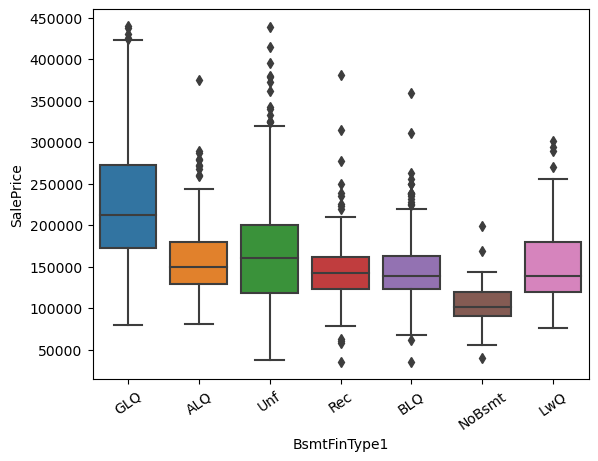

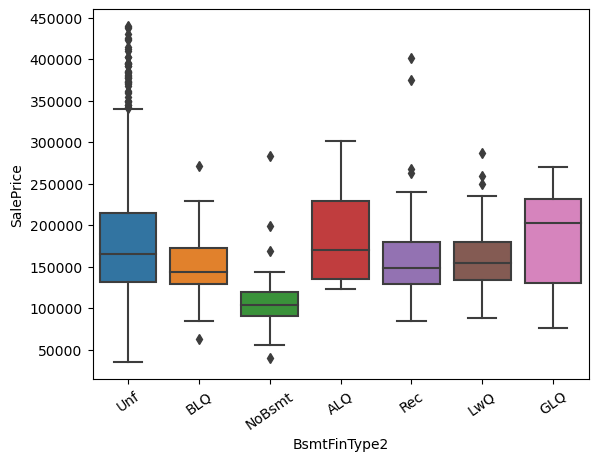

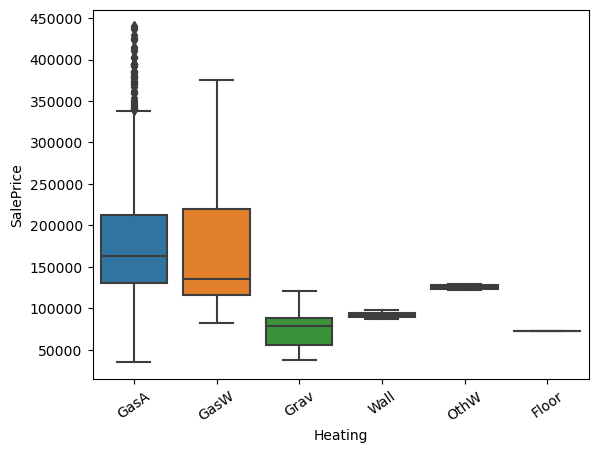

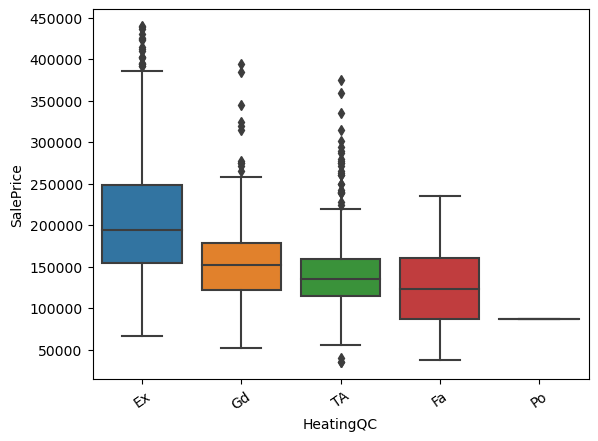

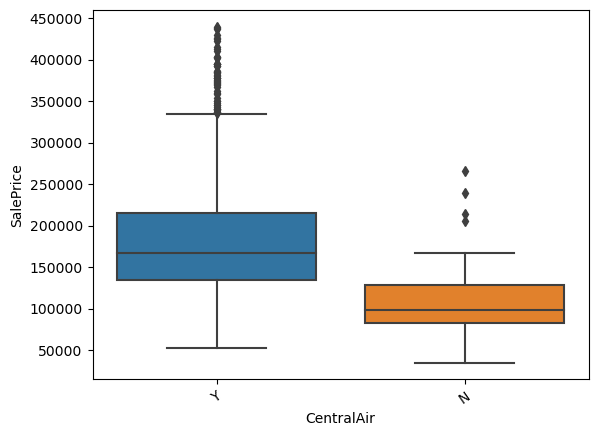

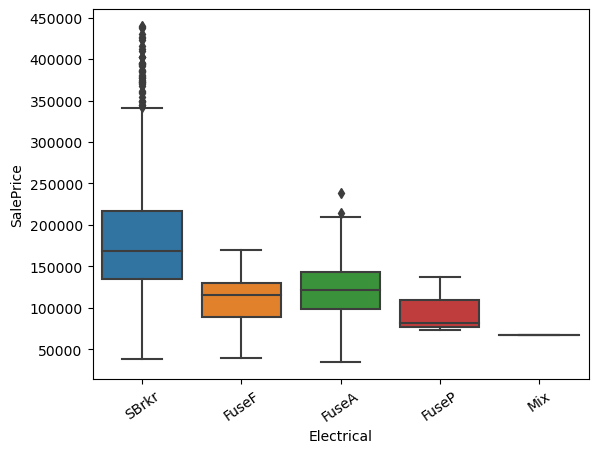

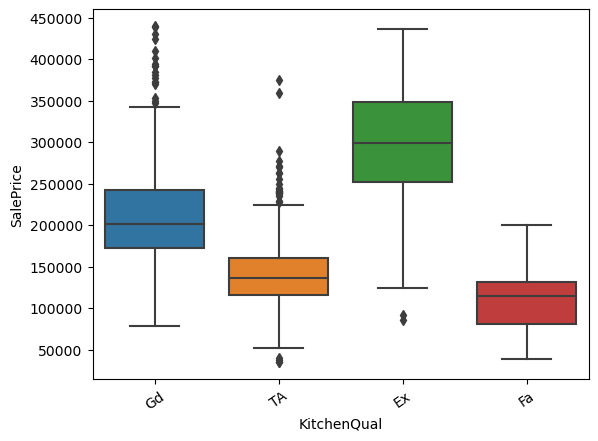

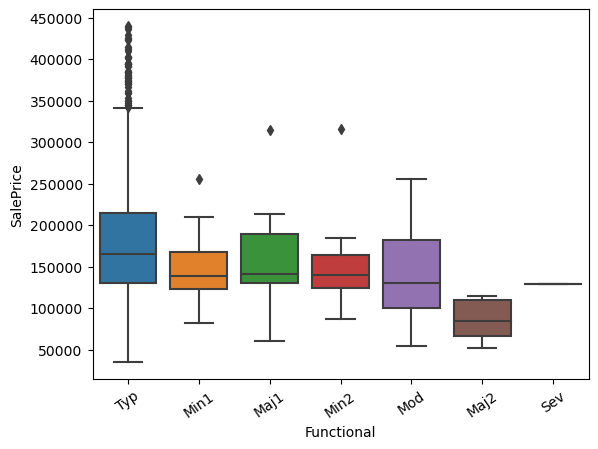

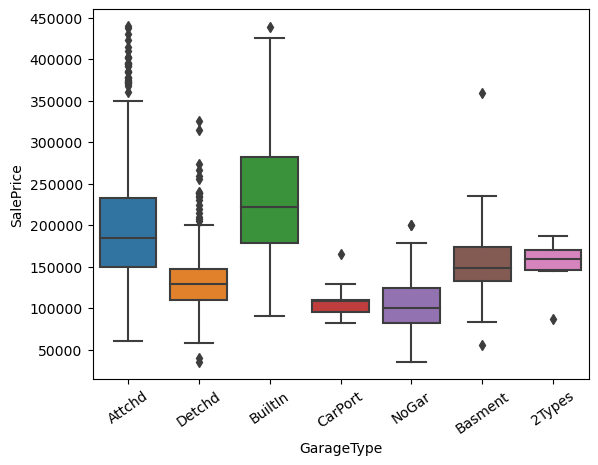

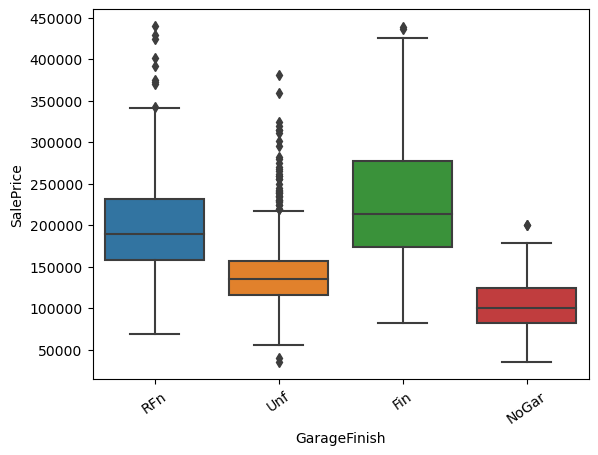

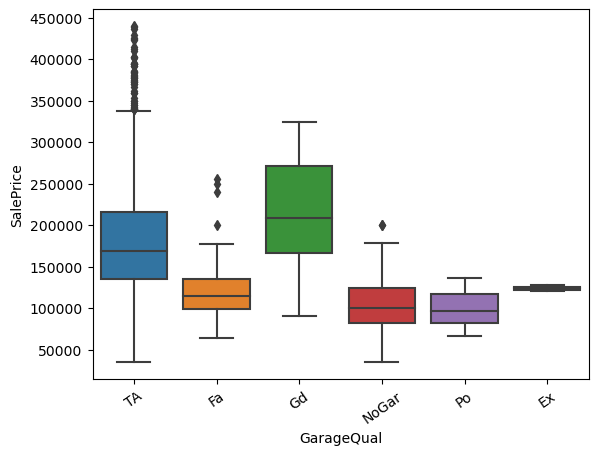

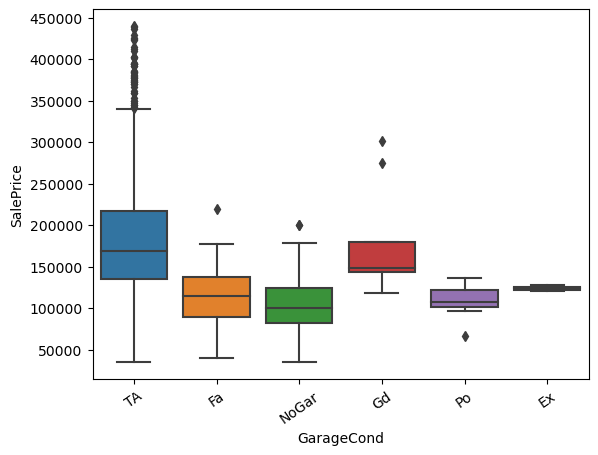

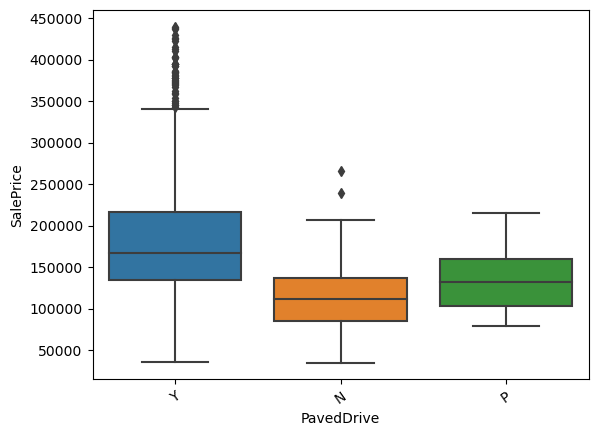

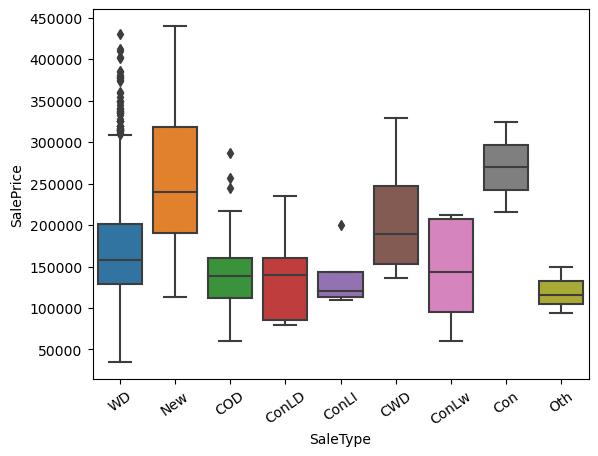

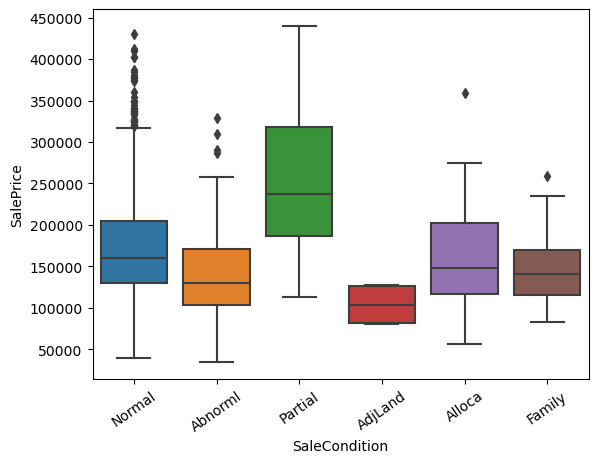

In [50]:
#Price vs all the Categorical Features
for i in house.select_dtypes('object').columns:
    sns.boxplot(x=house[i],y=house.SalePrice)
    plt.xticks(rotation=35)
    plt.show()

1. MS Subclass shows that properties classified as class 60 (2-STORY 1946 & NEWER) startes with higher price amount. Properties with class 30 being the lowest. 
2. MS Zone shows properties classified with Floating Village Residential are sold for a higher price. On the other hand more properties are being sold with Zone RL (Residential Low Density). The prices for RL varies from minimum to maximum. 
3. Regular and Slightly irregular properties are sold more. Redular properties are sold with higher prices.
4. Land Contour: Plot having flat land are sold more. Though HLS properties are sold at high price, properties with LandCounter seems to be very less.
5. Lot Config: Naturally Inside Lots are sold more as these types of properties will be high in any place. To be noticed is Cul-de-sac type and FR3 Lots are sold at pretty higher price. 
7. LandSlope : Properties with Gentle slop are sold more. Also, the upper quartile for properties with severe slope are very high. 
8. Neighborhood: Having CollgCr	and Northwest Ames have sold more. NoRidge, NridgHt and StoneBr properties are sold at a higher price.

11. 1 and 2 story houses have been sold more.

14. Exter Qual - Average/Good exterial quality have been sold more. Whereas exterior quality labelled as excellent is sold at a high price. IQR range falls at a higher price range. Similarly, Exter Cond with label 
15. Foundation with PConc and Cinder Block are sold more. Cinder Block IQR price range falls at very lower price as oposed to PConc.

__Removable Features:__
1. These Nominal features `Street, Utilities, Condition2, RoofMatl` and `Heating` are having high data imbalance with respect to its samples. Majority of the samples belongs to one type of category. 

In [51]:
#This will be removed as its not adding any value
house.Street.value_counts()

Street
Pave    1439
Grvl       6
Name: count, dtype: int64

In [52]:
#This will be removed as its not adding any value
house.Utilities.value_counts()

Utilities
AllPub    1444
NoSeWa       1
Name: count, dtype: int64

In [53]:
#This will be removed as its not adding any value
house.Condition2.value_counts()

Condition2
Norm      1430
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: count, dtype: int64

In [54]:
#This will be removed as its not adding any value
house.RoofMatl.value_counts()

RoofMatl
CompShg    1421
Tar&Grv      11
WdShake       5
WdShngl       4
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: count, dtype: int64

In [55]:
#This will be removed as its not adding any value
house.Heating.value_counts()

Heating
GasA     1413
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: count, dtype: int64

In [56]:
#Dropping following features because of the huge imbalance in the sample type
houseNominal.drop(['Condition2','Utilities','Street','RoofMatl','Heating'],axis=1,inplace=True)

1. Homes newly constructed are sold at a higher price. Also, homes with Contract 15% Down payment regular terms are sold for higher price
2. 

In [57]:
# Checking the scatter plot

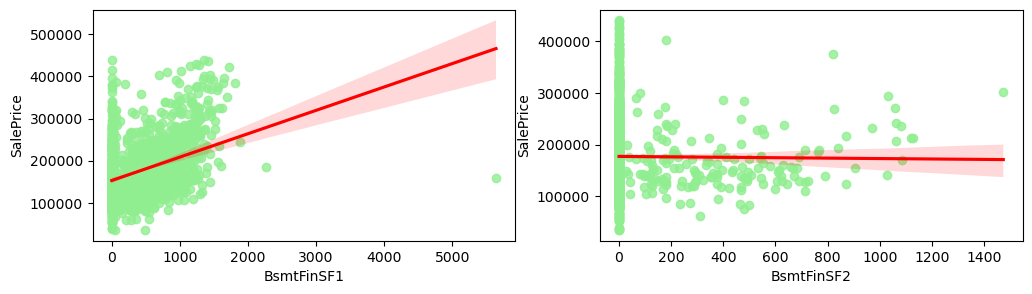

In [58]:
#Numerical
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.regplot(x=house.BsmtFinSF1,y=house.SalePrice,scatter_kws={'color': 'lightgreen'}, line_kws={'color': 'red'})
plt.subplot(1,2,2)
sns.regplot(x=house.BsmtFinSF2,y=house.SalePrice,scatter_kws={'color': 'lightgreen'}, line_kws={'color': 'red'})
plt.show()

1. Type1 Finished Basement is positvely correlated with SalePrice.
2. Type2 Finished Basement seems to be not related with SalePrice.

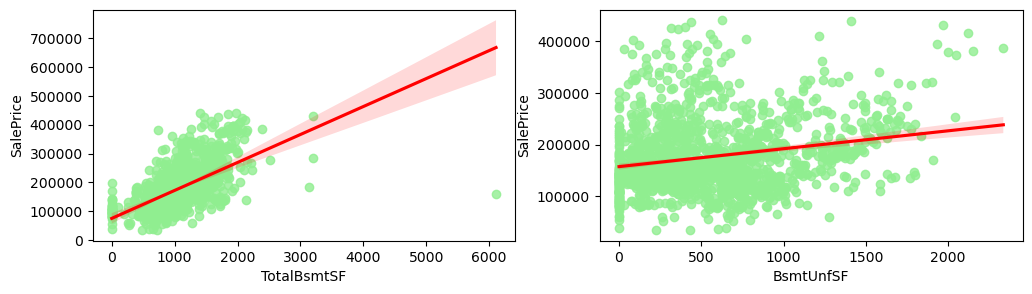

In [59]:
#Numerical
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.regplot(x=house.TotalBsmtSF,y=house.SalePrice,scatter_kws={'color': 'lightgreen'}, line_kws={'color': 'red'})
plt.subplot(1,2,2)
sns.regplot(x=house.BsmtUnfSF,y=house.SalePrice,scatter_kws={'color': 'lightgreen'}, line_kws={'color': 'red'})
plt.show()

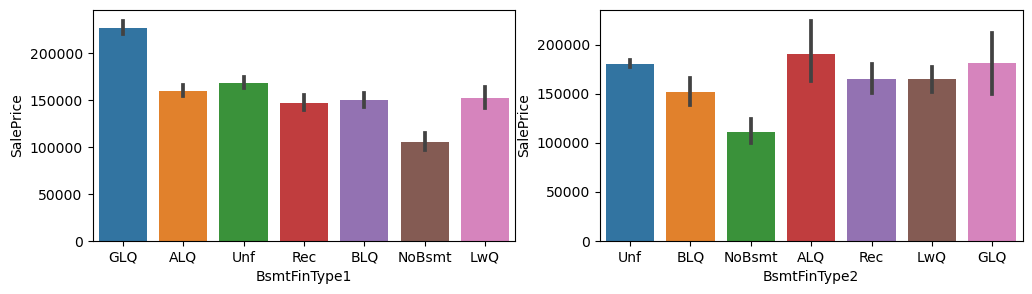

In [60]:
#Ordinal
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.barplot(x=house.BsmtFinType1,y=house.SalePrice)
plt.subplot(1,2,2)
sns.barplot(x=house.BsmtFinType2,y=house.SalePrice)
plt.show()

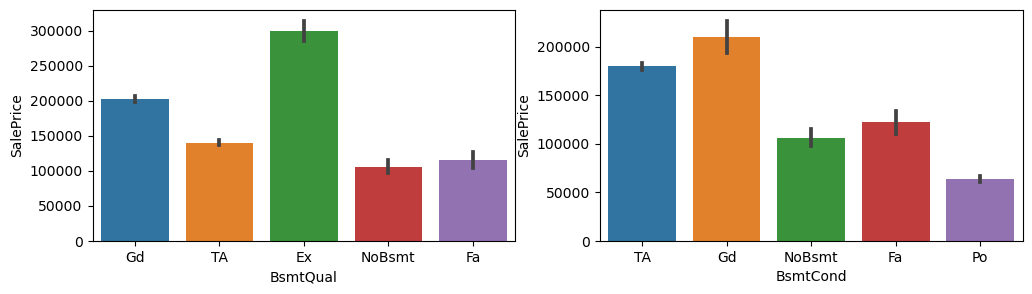

In [61]:
#Ordinal
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.barplot(x=house.BsmtQual,y=house.SalePrice)
plt.subplot(1,2,2)
sns.barplot(x=house.BsmtCond,y=house.SalePrice)
plt.show()

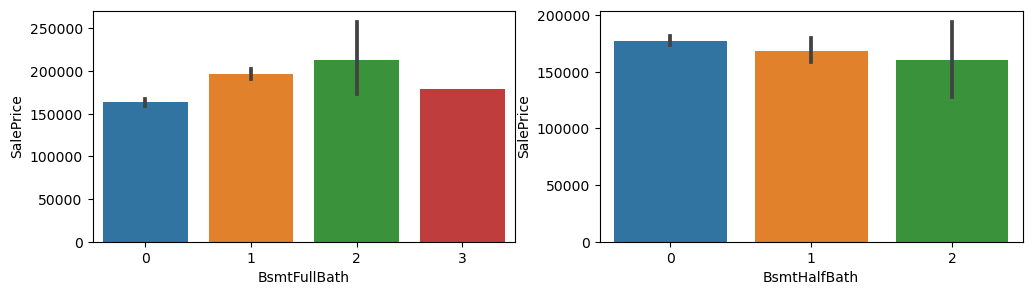

In [62]:
#Ordinal
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.barplot(x=house.BsmtFullBath,y=house.SalePrice)
plt.subplot(1,2,2)
sns.barplot(x=house.BsmtHalfBath,y=house.SalePrice)
plt.show()

<Axes: xlabel='BsmtExposure', ylabel='SalePrice'>

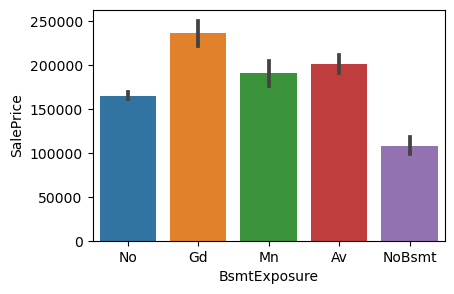

In [63]:
#Ordinal
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.barplot(x=house.BsmtExposure,y=house.SalePrice)


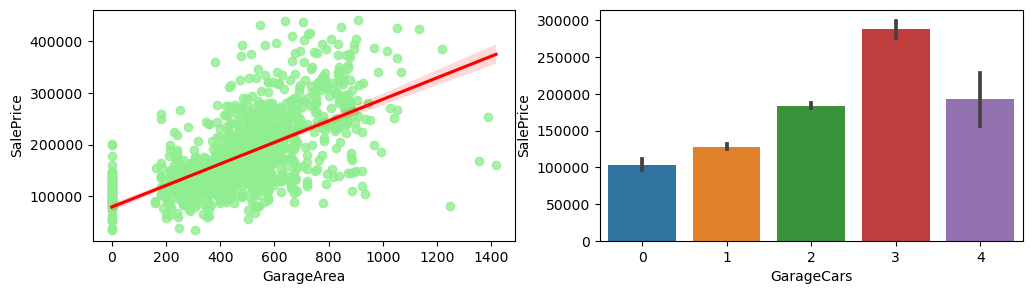

In [64]:
#Garage Analysis
#Numerical
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.regplot(x=house.GarageArea,y=house.SalePrice,scatter_kws={'color': 'lightgreen'}, line_kws={'color': 'red'})
#Ordinal
plt.subplot(1,2,2)
sns.barplot(x=house.GarageCars,y=house.SalePrice)
plt.show()


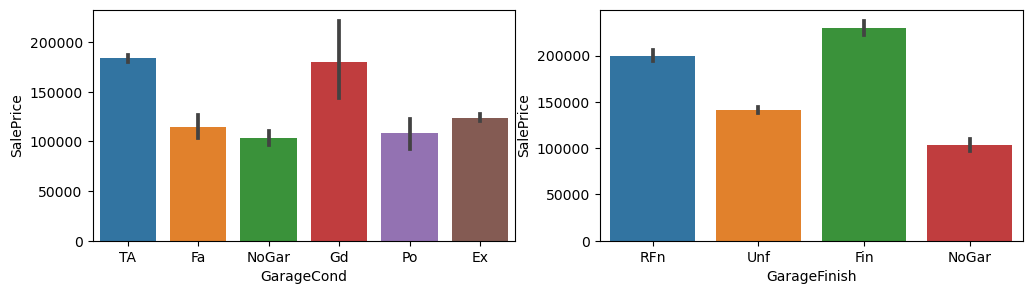

In [65]:
#Ordinal
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.barplot(x=house.GarageCond,y=house.SalePrice)
plt.subplot(1,2,2)
sns.barplot(x=house.GarageFinish,y=house.SalePrice)
plt.show()

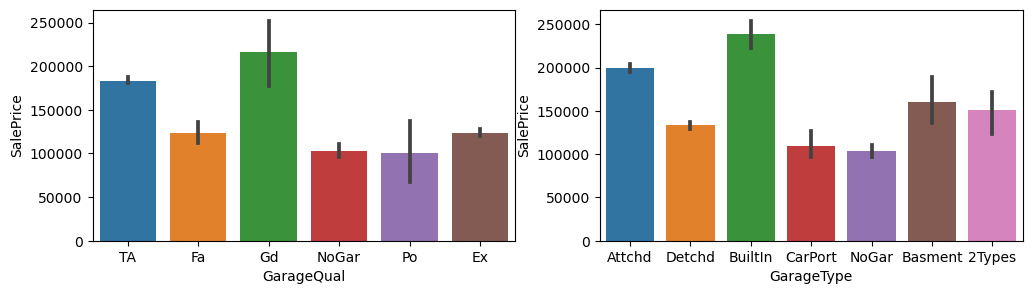

In [66]:
#ordinal
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
sns.barplot(x=house.GarageQual,y=house.SalePrice)
#Nominal
plt.subplot(1,2,2)
sns.barplot(x=house.GarageType,y=house.SalePrice)
plt.show()

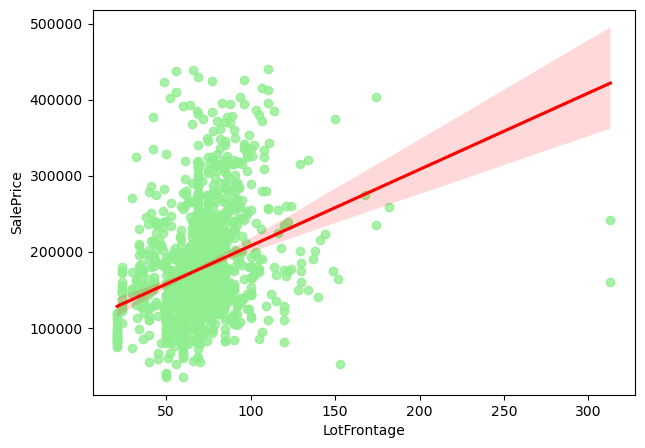

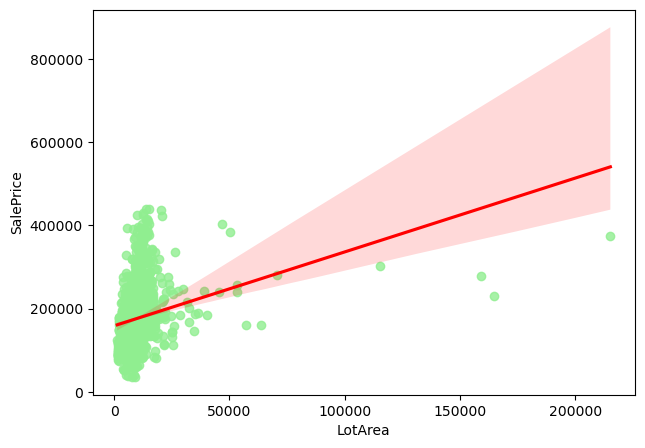

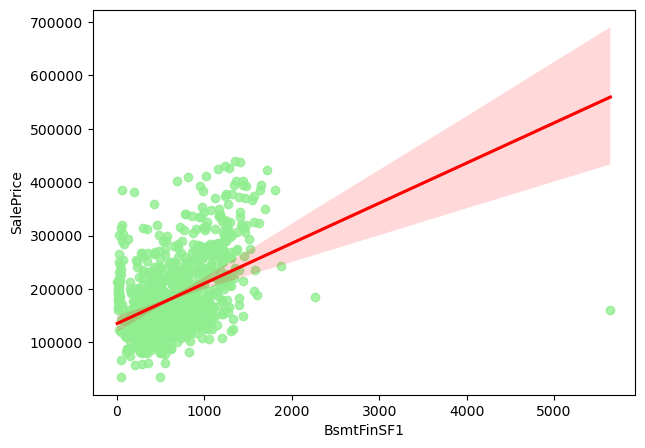

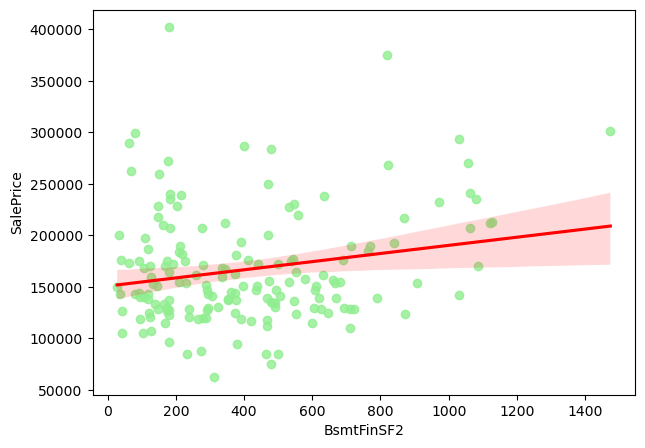

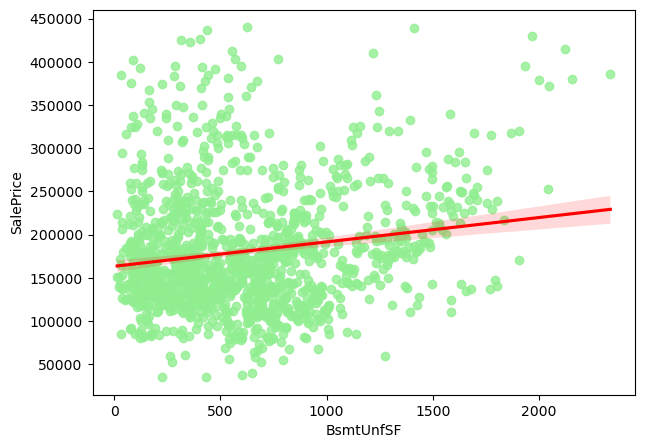

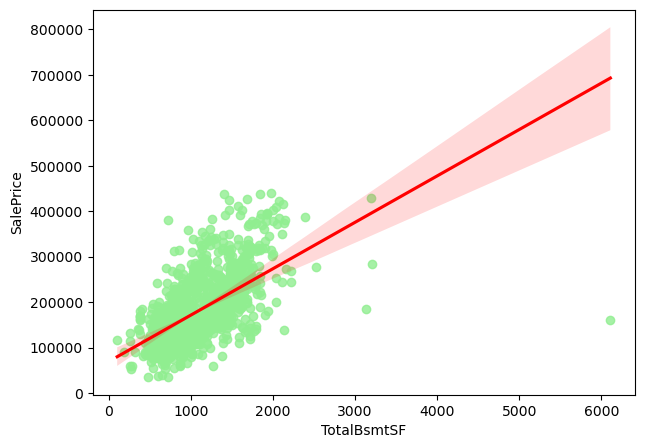

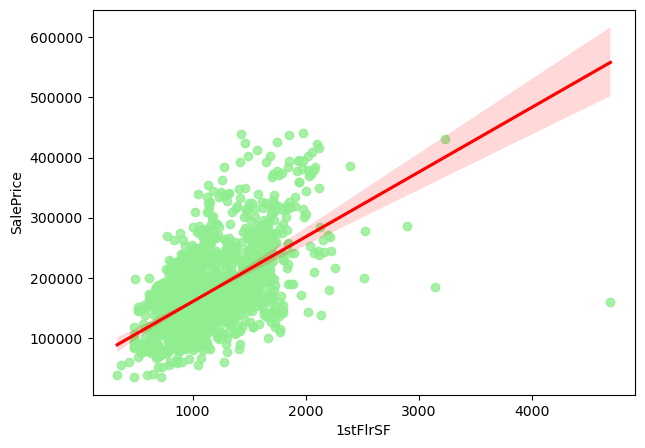

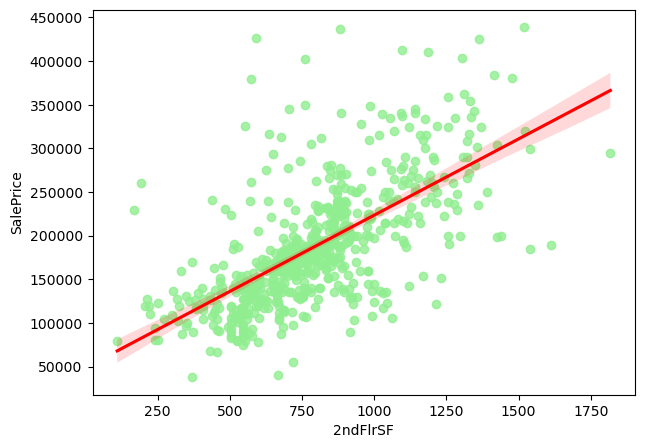

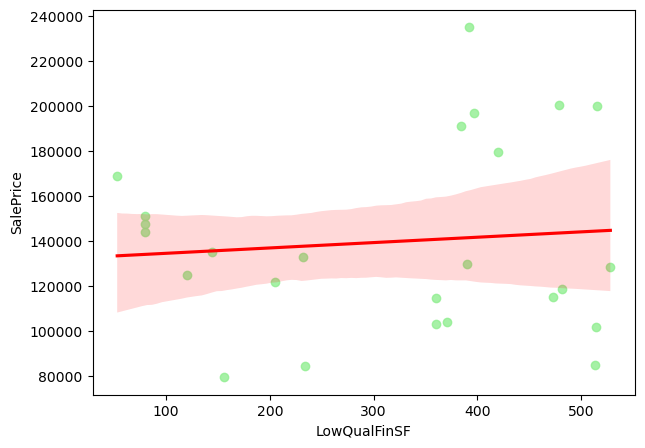

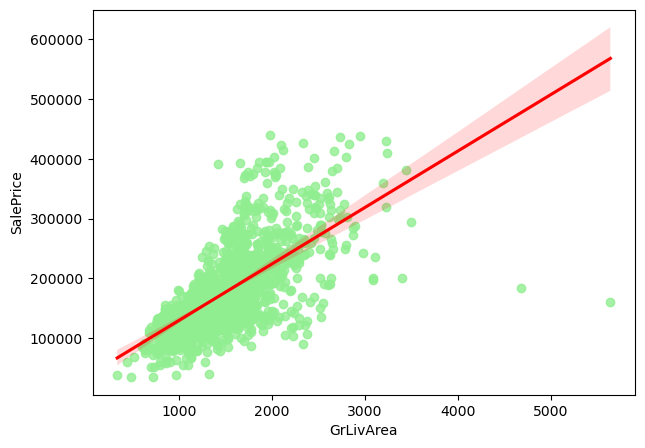

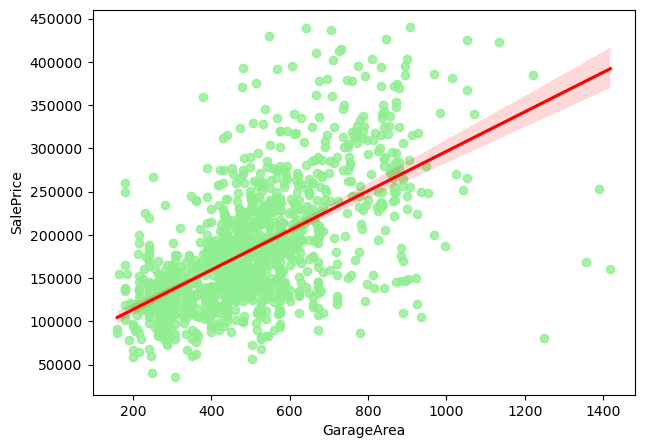

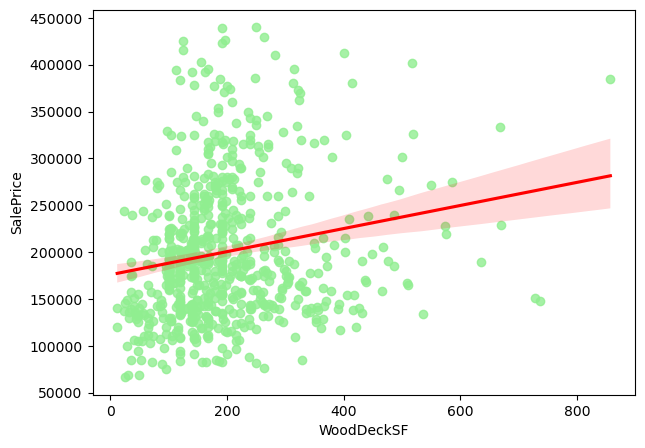

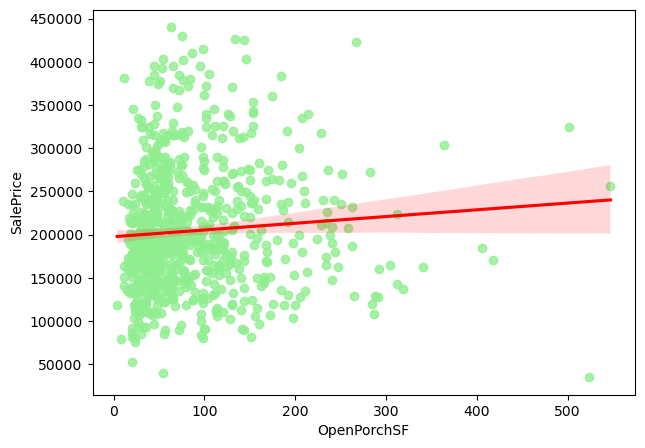

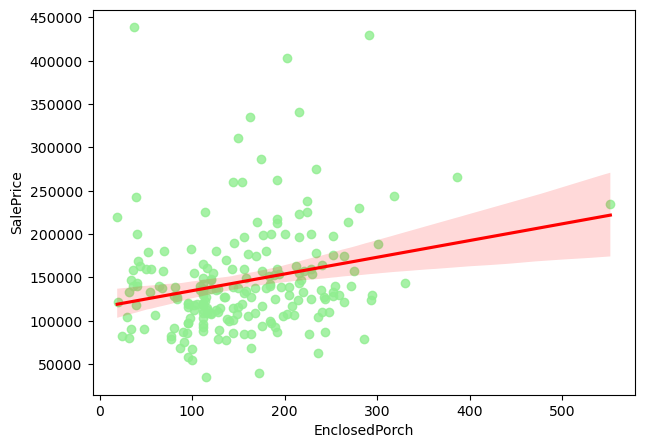

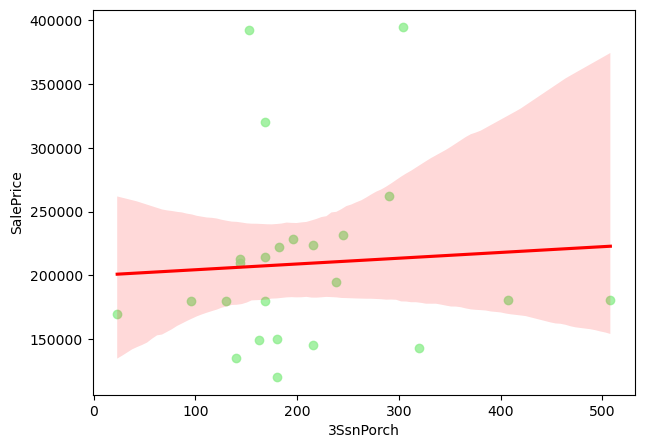

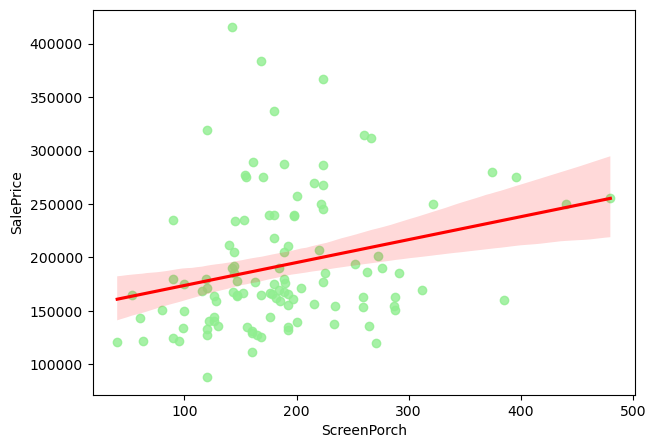

<Figure size 700x500 with 0 Axes>

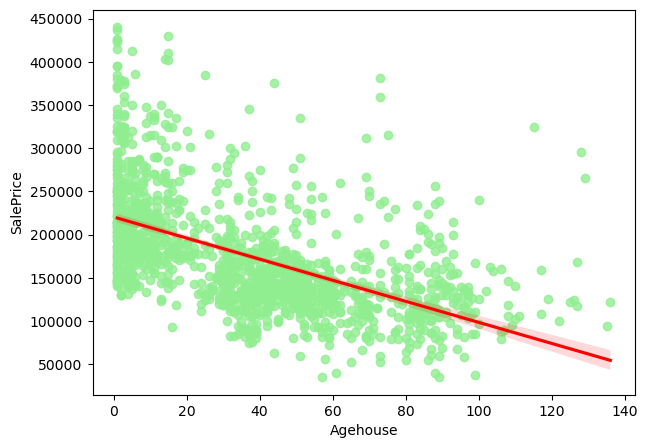

In [67]:
for i in houseCont.columns:
    plt.figure(figsize=(7,5))
    if i != 'SalePrice':
        sns.regplot(x=houseCont[houseCont[i]!=0][i],y=houseCont[houseCont[i]!=0].SalePrice ,scatter_kws={'color': 'lightgreen'}, line_kws={'color': 'red'})
        plt.show()

__Positvely correlated features:__
1. LotFrontage: Linear feet of street: Size of the street feet is positvely correlated to SalePrice
2. 1stFlrSF and 2ndFlrSF: There seems to be positively correlated

__Negative correlation:__
1. Age: This is a derived feature ( difference b/w Year Sold and  Year of house construction). Older houses are sold at a lower value.

__Weak Positive Correlation/Less data points:__
1. Lot Area: All the data points are at one place and very less data points are above 5000.
2. BsmtFinSF2: Very less data points and plot shows very weak positive correlation with slightly wide confidence interval.
3. BsmtUnfSF: Shows weak positve correlation
4. WoodDeckSF and OpenPorchSF: A large number of points are concentrated at the lower value of WoodDeckSF and Open Porce Area. The reg line shows weak positive correlation and some outliers are present at higher value. 
4. Enclosed Porch: Has very less data points and shows weak positive correlation
5. ScreenPorch: Data points are scattered more between 200 and 300. Reg plot shows weak positive correlation.

`Note`: Less data point indicates that respective properties doesn't have those features<br>
 `Weak correlations will retained and excluded post checking the model performance.` 

__Removable Features:__
1. 3SsnPorch ( Three season porch) and LowQualFinSF have very less samples to predict the relation ship with SalePrice. Regression line shows weak positive correlation and wide confidence interval which indicates more variability.


In [68]:
houseCont.drop(['3SsnPorch','LowQualFinSF'],axis=1,inplace=True)

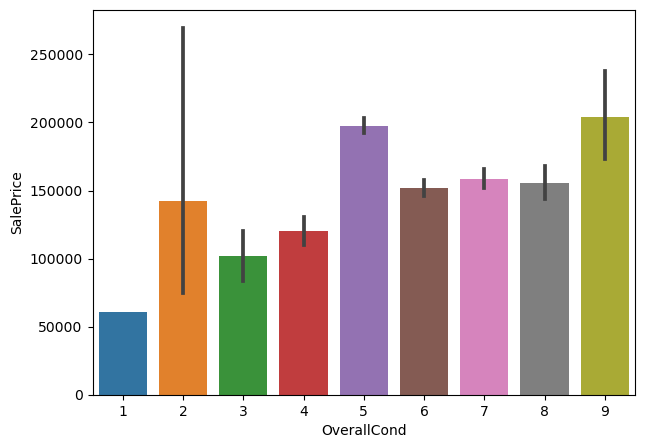

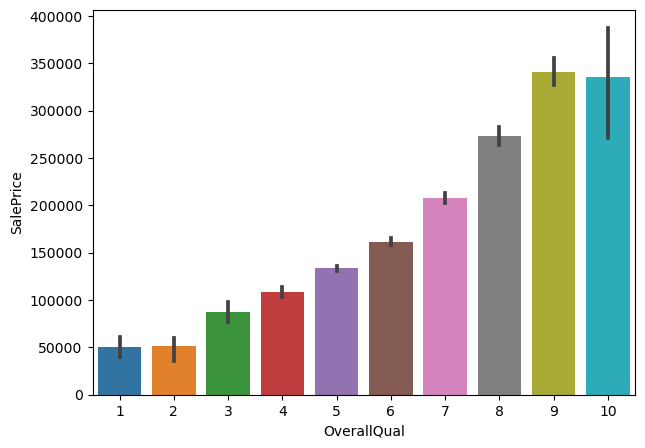

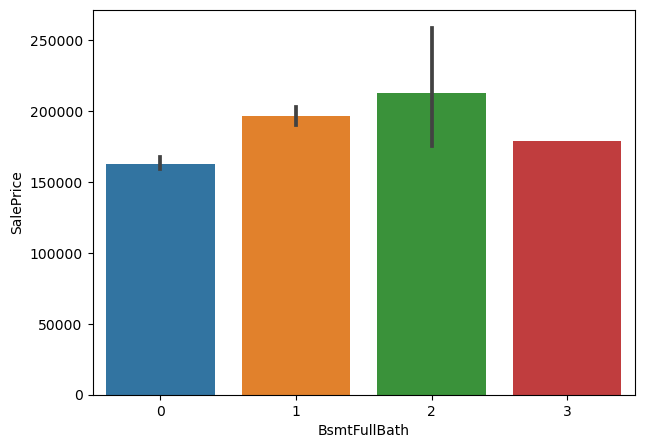

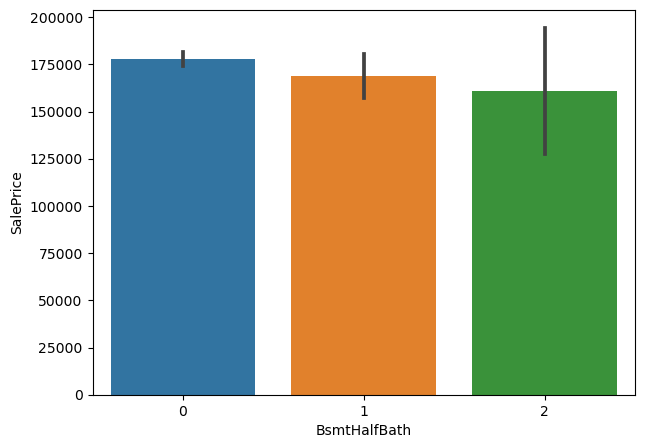

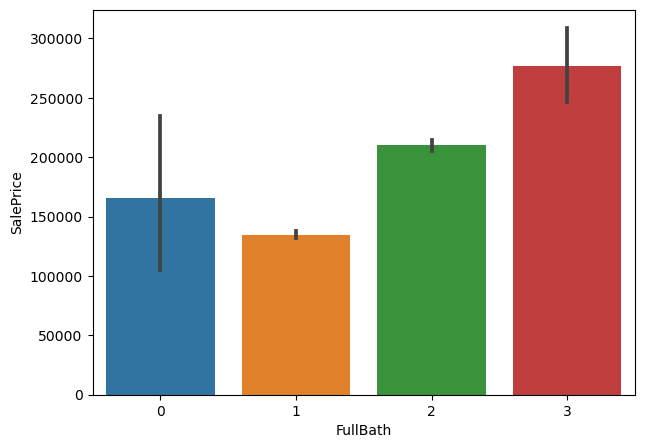

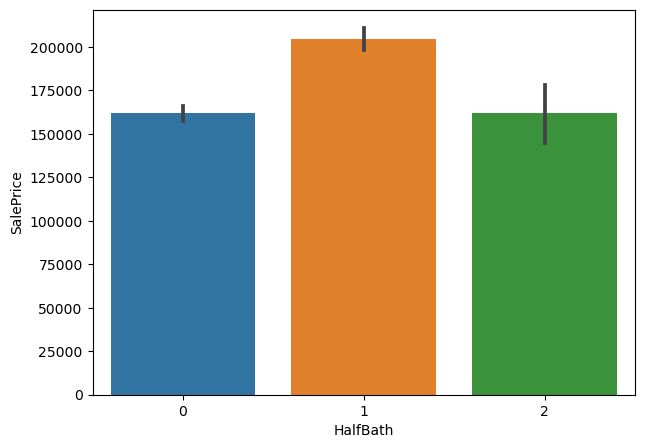

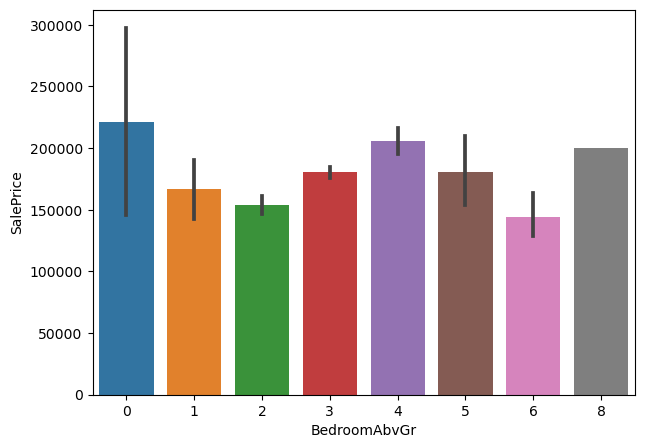

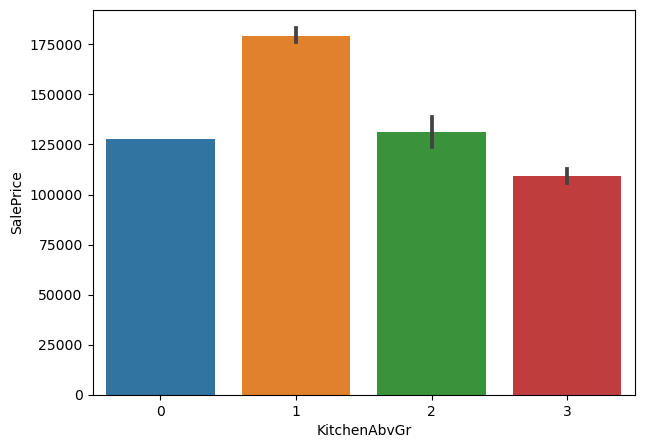

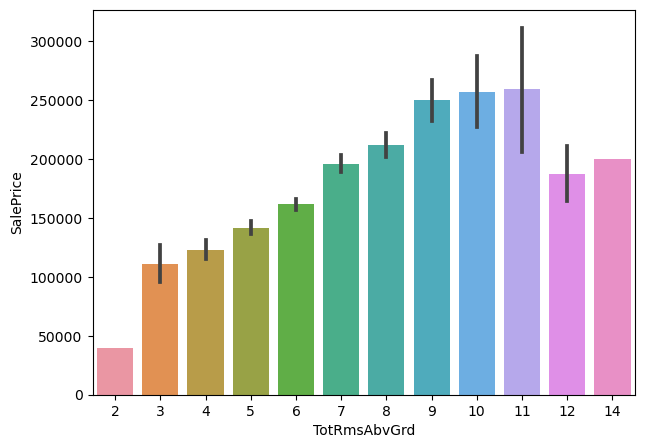

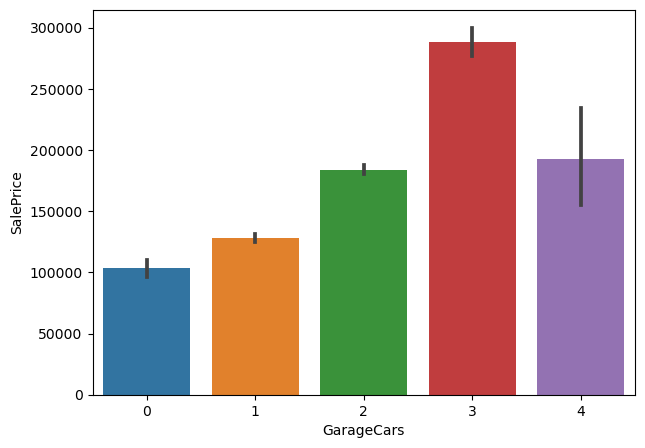

In [69]:
for i in houseNumOrdinal.columns:
    plt.figure(figsize=(7,5))
    sns.barplot(x=houseNumOrdinal[i],y=house.SalePrice)
    plt.show()

1. OverallQual of the property increases with Price.
2. Properties with Total rooms above grade up to 9-10 room have been sold for higher value.
3. Properties with Garage accomodating more cars have sold for higher value.


## 2. PreProcessing Steps for Model Building  

## A. Encoding

In [70]:
encoder = LabelEncoder()

In [71]:
houseCatOrdinal_ec = pd.DataFrame()
for i in houseCatOrdinal.columns:
    houseCatOrdinal_ec[i] = encoder.fit_transform(houseCatOrdinal[i])

In [72]:
houseCatOrdinal_ec.head()

ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
0          2          4         2         4             3             2   
1          3          4         2         4             1             0   
2          2          4         2         4             2             2   
3          3          4         4         1             3             0   
4          2          4         2         4             0             2   

   BsmtFinType2  HeatingQC  KitchenQual  GarageFinish  GarageQual  GarageCond  
0             6          0            2             2           5           5  
1             6          0            3             2           5           5  
2             6          0            2             2           5           5  
3             6          2            2             3           5           5  
4             6          0            2             2           5           5

In [73]:
#houseNominal_ec = pd.get_dummies(houseNominal,drop_first=True,dtype=int)
#Note Nominal variables are dummy encoded but here just to check the correlation with other variables, its label encoded.
houseNominal_ec = pd.DataFrame()
for i in houseNominal.columns:
    houseNominal_ec[i] = encoder.fit_transform(houseNominal[i])

In [74]:
houseNominal_ec.shape

(1445, 21)

In [75]:
#Final Data for linear regression analysis

house_temp = pd.concat([houseCatOrdinal_ec,houseNumOrdinal,houseNominal_ec,houseCont],axis=1)

In [76]:
house_temp.head()

ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
0          2          4         2         4             3             2   
1          3          4         2         4             1             0   
2          2          4         2         4             2             2   
3          3          4         4         1             3             0   
4          2          4         2         4             0             2   

   BsmtFinType2  HeatingQC  KitchenQual  GarageFinish  ...  1stFlrSF  \
0             6          0            2             2  ...       856   
1             6          0            3             2  ...      1262   
2             6          0            2             2  ...       920   
3             6          2            2             3  ...       961   
4             6          0            2             2  ...      1145   

   2ndFlrSF  GrLivArea  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
0       854       1710         548           0           61              0   
1         0       1262         460         298            0              0   
2       866       1786         608           0           42              0   
3       756       1717         642           0           35            272   
4      1053       2198         836         192           84              0   

   ScreenPorch  SalePrice  Agehouse  
0            0     208500         5  
1            0     181500        31  
2            0     223500         7  
3            0     140000        91  
4            0     250000         8  

[5 rows x 59 columns]

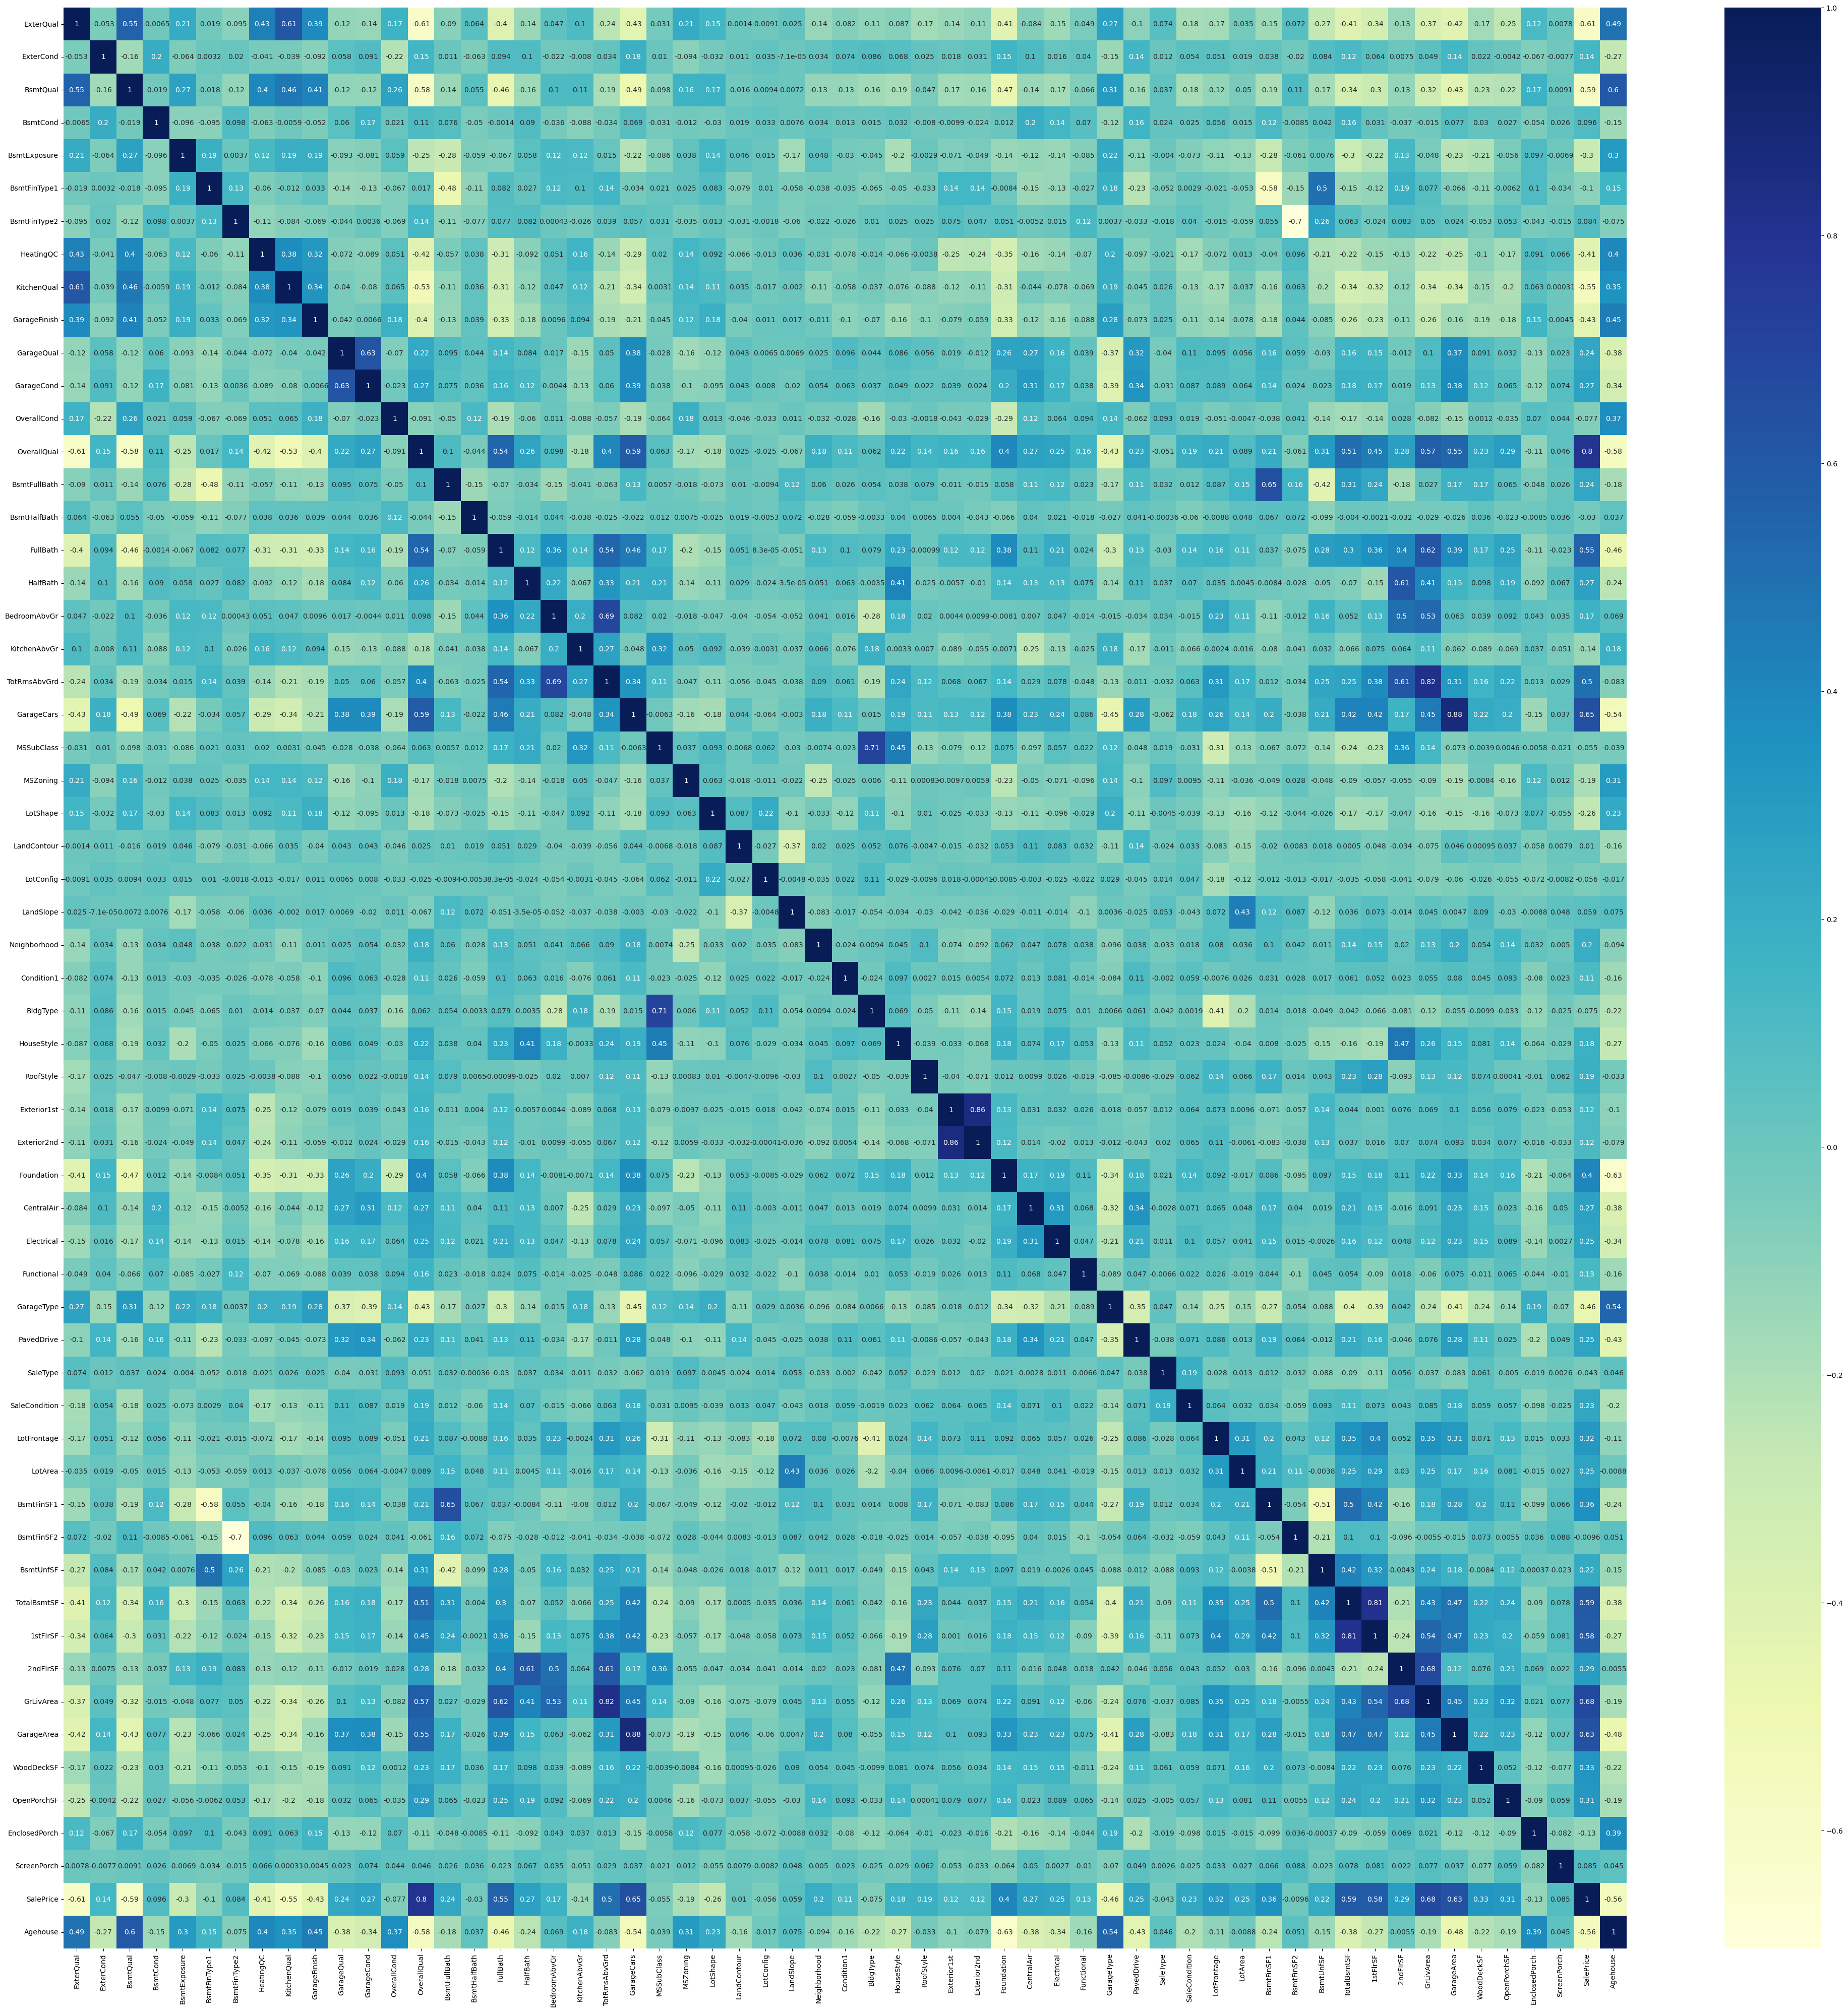

In [77]:
plt.figure(figsize=(50,50))
sns.heatmap(house_temp.corr(),annot=True,cmap='YlGnBu')
plt.show()

In [78]:
#1. GrLivArea - TotRmsAbvGrd are correlated
#GrLivArea is a sum of 1stFlrSF and 2ndFlrSF, so removing GrLivArea

#2. GarageArea - GarageCars
#Garage Cars capacity gives better picture, so removing GarageArea

#3. Exterior1st - Exterior2nd
# Both the parameters are barely correlated with SalesPrice. But for now removing Exterior2nd

#4.TotalBsmtSF - 1stFlrSF
# Removing TotalBsmtSF as its correlated with 1stFlrSF and properties without Bsmt have zero. Other Bsmt parameter explains this.


houseCont.drop(['GrLivArea','GarageArea','TotalBsmtSF'],axis=1,inplace=True)
houseNominal.drop(['Exterior2nd'],axis=1,inplace=True)

In [79]:
### 
houseNominal_ec = pd.get_dummies(houseNominal,drop_first=True,dtype=int)
houseNominal_ec.head()

MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  \
0              0              0              0              0              1   
1              0              0              0              0              0   
2              0              0              0              0              1   
3              0              0              0              0              0   
4              0              0              0              0              1   

   MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              1              0              0              0              0   
4              0              0              0              0              0   

   ...  SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  \
0  ...               0               0             0             0   
1  ...               0               0             0             0   
2  ...               0               0             0             0   
3  ...               0               0             0             0   
4  ...               0               0             0             0   

   SaleType_WD  SaleCondition_AdjLand  SaleCondition_Alloca  \
0            1                      0                     0   
1            1                      0                     0   
2            1                      0                     0   
3            1                      0                     0   
4            1                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 129 columns]

In [80]:
#Final house data set post encoding
house_final = pd.concat([houseCatOrdinal_ec,houseNumOrdinal,houseNominal_ec,houseCont],axis=1)
house_final.shape

(1445, 164)

## B. Data Split and Scaling the features 

In [81]:
y = house_final.pop('SalePrice')
X = house_final

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)

In [83]:
col = house_final.columns
sch = houseCont.drop(['SalePrice'],axis=1)
sch = sch.columns

In [84]:
#Scaling only continuous features. 
# Label encoded and Ordinal Numerical are not scaled.

scaler_X = StandardScaler()
scaler_y = StandardScaler()

#X_train[sch.columns] = scaler_X.fit_transform(X_train[sch.columns])
X_train[sch] = scaler_X.fit_transform(X_train[sch])
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

#This is needed when whole dataset is scaled
#X_train = pd.DataFrame(X_train)
#X_train.columns = col

In [85]:
#X_test[sch.columns] = scaler_X.transform(X_test[sch.columns])
X_test[sch] = scaler_X.transform(X_test[sch])
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

#This is needed when whole dataset is scaled
#X_test = pd.DataFrame(X_test)
#X_test.columns = col

In [86]:
sch

Index(['LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       '1stFlrSF', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ScreenPorch', 'Agehouse'],
      dtype='object')

In [87]:
X_test.head()

ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
1164          3          4         4         4             3             0   
30            3          1         4         4             3             6   
886           3          4         4         4             3             1   
1191          3          4         2         4             3             0   
275           3          4         4         4             3             3   

      BsmtFinType2  HeatingQC  KitchenQual  GarageFinish  ...  BsmtFinSF1  \
1164             6          4            3             3  ...    0.488077   
30               6          4            3             3  ...   -0.954163   
886              6          4            3             2  ...   -0.077422   
1191             6          0            3             2  ...    0.773018   
275              6          0            3             3  ...   -0.691141   

      BsmtFinSF2  BsmtUnfSF  1stFlrSF  2ndFlrSF  WoodDeckSF  OpenPorchSF  \
1164   -0.289797  -0.789220 -0.613796 -0.789884    2.194256    -0.711396   
30     -0.289797   0.192550 -1.349223  0.802275   -0.750888     0.114768   
886    -0.289797  -0.420202 -0.452753  1.147878   -0.750888     0.053570   
1191   -0.289797  -0.675326 -0.208506 -0.789884   -0.750888     0.634945   
275    -0.289797   0.408950 -0.772154 -0.789884   -0.750888    -0.711396   

      EnclosedPorch  ScreenPorch  Agehouse  
1164      -0.368117    -0.271281 -0.419397  
30         2.583407    -0.271281  1.698010  
886       -0.368117    -0.271281  0.275377  
1191      -0.368117    -0.271281 -0.187806  
275       -0.368117    -0.271281  0.738560  

[5 rows x 163 columns]

# 3. Model Building and Evaluation

### Base Model built using statsmodel 

In [88]:
X_train_sm = sm.add_constant(X_train)
lr_model = sm.OLS(y_train,X_train_sm).fit()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     51.28
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        21:57:11   Log-Likelihood:                -242.08
No. Observations:                1011   AIC:                             804.2
Df Residuals:                     851   BIC:                             1591.
Df Model:                         159                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.00

In [89]:
# Checking VIF for the remaining independent variables
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [ variance_inflation_factor(X_train,i) for i in range(X_train.shape[1])]
vif.sort_values('VIF',ascending=False, inplace=True)
print(vif)
print('Infinite values are present')

                Features         VIF
31         MSSubClass_90         inf
85       BldgType_Duplex         inf
38           MSZoning_RL  225.171120
130    GarageType_Attchd  207.871650
95       RoofStyle_Gable  199.141554
..                   ...         ...
82       Condition1_RRNe    1.206843
144         SaleType_Oth    1.160941
100  Exterior1st_AsphShn         NaN
106  Exterior1st_ImStucc         NaN
128       Functional_Sev         NaN

[163 rows x 2 columns]
Infinite values are present


VIF score shows that features are highly co-related.

### Basic Model evaluation

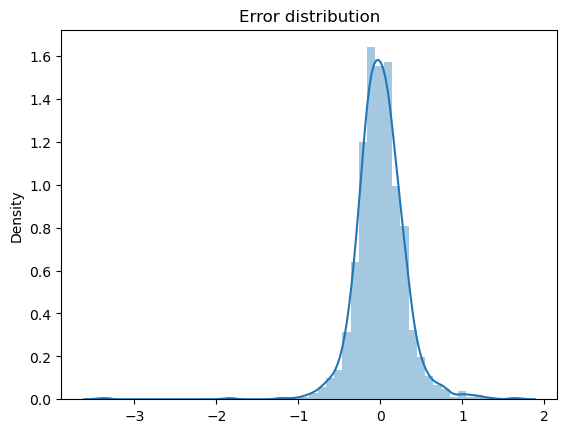

In [90]:
#Lets use this model to check the results on test data set before proceeding further
y_base_train_pred = lr_model.predict(X_train_sm)
res = y_train.flatten() - y_base_train_pred
sns.distplot(res)
plt.title('Error distribution')
plt.show()

#### Checking the Basic Model on Test set

In [91]:
#For some weird reason r2 value of test using statsmodel is giving higher r2 than actual value

#Use has_constant='add' in sm.add_constant to ensure it adds a constant even if it suspects there might already be one.
#X_test_sm = sm.add_constant(X_test, has_constant='add')
#X_test_sm = sm.add_constant(X_test)
#y_test_pred = lr_model.predict(X_test_sm)
#testscore = r2_score(y_true=y_test,y_pred=y_test_pred)
#print('This is r2 on test set',round(testscore,3))

In [92]:
blm = LinearRegression()
baseLR = blm.fit(X_train,y_train)
baseytrainpred = baseLR.predict(X_train)
baseytestpred = baseLR.predict(X_test)
print('This is r2 on train set',r2_score(y_true=y_train,y_pred=baseytrainpred))
print('This is r2 on test set',r2_score(y_true=y_test,y_pred=baseytestpred))

This is r2 on train set 0.9054820378280423
This is r2 on test set -133420083751675.75


Linear Regression Base model is giving following values with total features of 163:
 
1. Train set r2 value 0.905 
2. Test set r2 value -133420083751675.75

This is perfect example of overfitting. There are multiple ways to fix this issue. As per the problem statement, there is an ask to use Regularization. So, lets use it

### Optional - Using RFE

In [93]:
lm = LinearRegression()

In [94]:
# Selecting top 115 features
no_of_RFEfeatures =115
rfe = RFE(lm, n_features_to_select=no_of_RFEfeatures)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=115)

In [95]:
list(zip(X.columns,rfe.support_,rfe.ranking_))

[('ExterQual', True, 1),
 ('ExterCond', False, 35),
 ('BsmtQual', True, 1),
 ('BsmtCond', True, 1),
 ('BsmtExposure', True, 1),
 ('BsmtFinType1', False, 32),
 ('BsmtFinType2', False, 7),
 ('HeatingQC', False, 38),
 ('KitchenQual', True, 1),
 ('GarageFinish', True, 1),
 ('GarageQual', False, 49),
 ('GarageCond', False, 46),
 ('OverallCond', True, 1),
 ('OverallQual', True, 1),
 ('BsmtFullBath', True, 1),
 ('BsmtHalfBath', True, 1),
 ('FullBath', True, 1),
 ('HalfBath', True, 1),
 ('BedroomAbvGr', True, 1),
 ('KitchenAbvGr', True, 1),
 ('TotRmsAbvGrd', True, 1),
 ('GarageCars', True, 1),
 ('MSSubClass_30', False, 37),
 ('MSSubClass_40', True, 1),
 ('MSSubClass_45', True, 1),
 ('MSSubClass_50', True, 1),
 ('MSSubClass_60', False, 28),
 ('MSSubClass_70', False, 26),
 ('MSSubClass_75', True, 1),
 ('MSSubClass_80', True, 1),
 ('MSSubClass_85', False, 6),
 ('MSSubClass_90', True, 1),
 ('MSSubClass_120', True, 1),
 ('MSSubClass_160', True, 1),
 ('MSSubClass_180', True, 1),
 ('MSSubClass_190', 

In [96]:
#Extracting the reduced values:
rfecol = X_train.columns[rfe.support_]
X_train_rfe = X_train[rfecol]
X_train_rfe.shape

(1011, 115)

In [97]:
#rfecol


In [98]:
#Fitting the linear model on the reduced feature set 
lm.fit(X_train_rfe,y_train)


LinearRegression()

In [99]:
# Print the coefficients and intercept
#print(lm.intercept_)
#print(lm.coef_)

In [100]:
metric = []
print('Total no of features selected:',no_of_RFEfeatures)

# Checking the r2 on train data set
y_train_pred_rfe = lm.predict(X_train_rfe)
#y_train_pred_rfe = rfe.predict(X_train)
r2_train_lr = r2_score(y_true=y_train, y_pred=y_train_pred_rfe)
rss_train_rfe = np.sum(np.square(y_train - y_train_pred_rfe))
mse_train_rfe = mean_squared_error(y_train, y_train_pred_rfe)
print('RFE model train r2:',r2_train_lr)


# Checking the r2 on test data set
X_test_rfe = X_test[X_train_rfe.columns]
y_test_pred_rfe = lm.predict(X_test[X_train_rfe.columns])
#y_test_pred_rfe = rfe.predict(X_test)
r2_test_lr = r2_score(y_true=y_test,y_pred= y_test_pred_rfe)
rss_test_rfe = np.sum(np.square(y_test - y_test_pred_rfe))
mse_test_rfe = mean_squared_error(y_test, y_test_pred_rfe)
print('RFE model test r2:',r2_test_lr)


metric.append(no_of_RFEfeatures)
metric.append(r2_train_lr)
metric.append(r2_test_lr)
metric.append(rss_train_rfe)
metric.append(rss_test_rfe)
metric.append(mse_train_rfe)
metric.append(mse_test_rfe)

Total no of features selected: 115
RFE model train r2: 0.9001996658165016
RFE model test r2: -2.903452734722204e+16


In [101]:
#Following reduced data set will be regularized. Here is the train and test data set
X_train_rfe.head()

ExterQual  BsmtQual  BsmtCond  BsmtExposure  KitchenQual  GarageFinish  \
160           3         2         4             3            3             3   
452           3         4         4             3            3             3   
545           2         2         4             3            2             0   
106           3         1         4             3            3             3   
1293          3         2         1             3            3             3   

      OverallCond  OverallQual  BsmtFullBath  BsmtHalfBath  ...  \
160             6            6             0             0  ...   
452             6            7             0             0  ...   
545             5            7             0             0  ...   
106             7            4             0             0  ...   
1293            5            5             1             0  ...   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
160                      0                     0                     1   
452                      0                     0                     1   
545                      0                     0                     1   
106                      0                     0                     1   
1293                     0                     0                     1   

      SaleCondition_Partial  LotFrontage   LotArea  BsmtUnfSF  1stFlrSF  \
160                       0    -0.010549  0.079389   0.017153  0.215573   
452                       0     0.515530 -0.071029  -0.543208  0.242413   
545                       0     0.276403 -0.093295   0.791636 -0.643320   
106                       0    -0.440978  0.047722   0.174327 -0.280975   
1293                      0    -0.440978 -0.222239  -0.729995 -0.433965   

      2ndFlrSF  OpenPorchSF  
160  -0.789884    -0.711396  
452  -0.789884    -0.711396  
545   2.027379     2.073081  
106  -0.789884    -0.711396  
1293 -0.789884     0.267761  

[5 rows x 115 columns]

In [102]:
X_test_rfe.head()

ExterQual  BsmtQual  BsmtCond  BsmtExposure  KitchenQual  GarageFinish  \
1164          3         4         4             3            3             3   
30            3         4         4             3            3             3   
886           3         4         4             3            3             2   
1191          3         2         4             3            3             2   
275           3         4         4             3            3             3   

      OverallCond  OverallQual  BsmtFullBath  BsmtHalfBath  ...  \
1164            5            5             1             0  ...   
30              4            4             0             0  ...   
886             5            6             1             0  ...   
1191            6            5             1             0  ...   
275             5            4             0             0  ...   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
1164                     0                     0                     1   
30                       0                     0                     1   
886                      0                     0                     1   
1191                     0                     0                     1   
275                      0                     0                     1   

      SaleCondition_Partial  LotFrontage   LotArea  BsmtUnfSF  1stFlrSF  \
1164                      0    -1.540962 -0.333172  -0.789220 -0.613796   
30                        0    -0.919232 -0.179885   0.192550 -1.349223   
886                       0     0.085102 -0.322782  -0.420202 -0.452753   
1191                      0     0.419880 -0.017591  -0.675326 -0.208506   
275                       0     3.385055  0.872844   0.408950 -0.772154   

      2ndFlrSF  OpenPorchSF  
1164 -0.789884    -0.711396  
30    0.802275     0.114768  
886   1.147878     0.053570  
1191 -0.789884     0.634945  
275  -0.789884    -0.711396  

[5 rows x 115 columns]

### Lasso Regularization

In [103]:
lasso = Lasso()
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0 ]}
folds=5

# cross validation
model_cv = GridSearchCV(estimator = lasso, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True,verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [104]:
cv_result = pd.DataFrame(model_cv.cv_results_)

In [105]:
cv_result[['params','std_train_score','mean_train_score','mean_test_score']]

params  std_train_score  mean_train_score  mean_test_score
0   {'alpha': 0.0001}         0.010511          0.906007         0.842017
1    {'alpha': 0.001}         0.011218          0.898678         0.846108
2     {'alpha': 0.01}         0.018088          0.850308         0.813733
3     {'alpha': 0.05}         0.017958          0.802504         0.783572
4      {'alpha': 0.1}         0.011238          0.760101         0.749041
5      {'alpha': 0.2}         0.013222          0.695760         0.688995
6      {'alpha': 0.3}         0.012358          0.631622         0.625972
7      {'alpha': 0.4}         0.011248          0.564127         0.559501
8      {'alpha': 0.5}         0.010651          0.495856         0.491552
9      {'alpha': 0.6}         0.012948          0.432131         0.427288
10     {'alpha': 0.7}         0.016274          0.357769         0.351923
11     {'alpha': 0.8}         0.020398          0.271967         0.264935
12     {'alpha': 0.9}         0.025261          0.174725         0.166326
13     {'alpha': 1.0}         0.030823          0.066042         0.056094
14     {'alpha': 2.0}         0.000000          0.000000        -0.011861
15     {'alpha': 3.0}         0.000000          0.000000        -0.011861
16     {'alpha': 4.0}         0.000000          0.000000        -0.011861
17     {'alpha': 5.0}         0.000000          0.000000        -0.011861

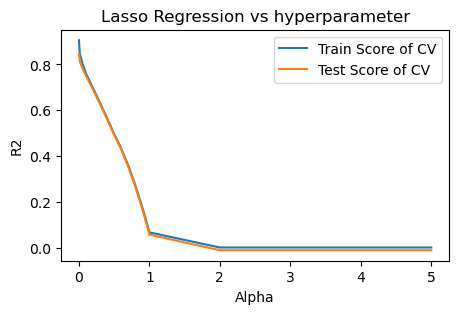

In [106]:
values = [d['alpha'] for d in cv_result['params'].values]
cv_result['param_alpha'] = cv_result['param_alpha'].astype('int32')
plt.figure(figsize=(5,3))
plt.plot(values, cv_result['mean_train_score'], label='Train Score of CV')
plt.plot(values, cv_result['mean_test_score'], label='Test Score of CV')
plt.xlabel('Alpha')
plt.ylabel('R2')
plt.title('Lasso Regression vs hyperparameter')
plt.legend()
plt.show()

In [107]:
model_cv.best_params_

{'alpha': 0.001}

In [108]:
alpha = 0.001
lasso = Lasso(alpha=alpha)
lasso.fit(X_train_rfe,y_train)

Lasso(alpha=0.001)

In [109]:
#Lasso Coefficients
MainLassoCoeff = pd.Series(lasso.coef_,index=X_train_rfe.columns)
abs(MainLassoCoeff[MainLassoCoeff !=0]).sort_values(ascending=False)

Neighborhood_NoRidge    0.508991
LotShape_IR3            0.468144
Neighborhood_NridgHt    0.425812
Neighborhood_StoneBr    0.346527
MSSubClass_120          0.298645
                          ...   
SaleCondition_Alloca    0.013237
Condition1_RRAn         0.011538
RoofStyle_Gable         0.011134
GarageType_Basment      0.010546
Neighborhood_SawyerW    0.006244
Length: 69, dtype: float64

In [110]:
#Following co-efficients have been penalized to ZERO by lasso model.
MainLassoCoeff[MainLassoCoeff ==0]

BsmtHalfBath            0.0
MSSubClass_40          -0.0
MSSubClass_45           0.0
MSSubClass_75           0.0
MSSubClass_80          -0.0
MSSubClass_90          -0.0
MSSubClass_180         -0.0
MSZoning_RH             0.0
MSZoning_RM            -0.0
LotConfig_FR3          -0.0
LandSlope_Sev          -0.0
Neighborhood_NPkVill    0.0
Neighborhood_SWISU      0.0
Neighborhood_Timber     0.0
Condition1_RRAe        -0.0
Condition1_RRNe         0.0
Condition1_RRNn         0.0
BldgType_Duplex        -0.0
HouseStyle_1.5Unf       0.0
HouseStyle_2.5Fin      -0.0
HouseStyle_2.5Unf       0.0
HouseStyle_SFoyer      -0.0
HouseStyle_SLvl        -0.0
RoofStyle_Gambrel       0.0
RoofStyle_Hip           0.0
RoofStyle_Mansard      -0.0
RoofStyle_Shed          0.0
Exterior1st_AsphShn     0.0
Exterior1st_BrkComm     0.0
Exterior1st_ImStucc     0.0
Exterior1st_Stone      -0.0
Exterior1st_Wd Sdng    -0.0
Exterior1st_WdShing    -0.0
Foundation_Wood        -0.0
Electrical_Mix         -0.0
Electrical_SBrkr    

In [111]:
metric_lasso=[]
y_train_pred_lasso = lasso.predict(X_train_rfe)
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
rss_train_lasso = np.sum(np.square(y_train - y_train_pred_lasso))
mse_train_lasso = mean_squared_error(y_train, y_train_pred_lasso)
print('Lasso Train Model value r2:',r2_train_lasso)


#y_test_pred = lasso.predict(X_test[lasso.feature_names_in_])
y_test_pred_lasso = lasso.predict(X_test[X_train_rfe.columns])
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)
rss_test_lasso = np.sum(np.square(y_test - y_test_pred_lasso))
mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)

print('Lasso Test Set value r2:',r2_test_lasso)


metric_lasso.append(model_cv.best_params_)
metric_lasso.append(r2_train_lasso)
metric_lasso.append(r2_test_lasso)
metric_lasso.append(rss_train_lasso)
metric_lasso.append(rss_test_lasso)
metric_lasso.append(mse_train_lasso)
metric_lasso.append(mse_test_lasso)

Lasso Train Model value r2: 0.8939960156755192
Lasso Test Set value r2: 0.8393946241843337


### Lasso Model Evaluation

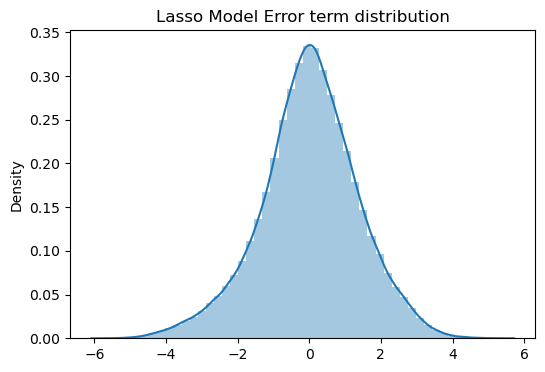

In [112]:
plt.figure(figsize=(6,4))
sns.distplot(y_train_pred_lasso-y_train)
plt.title('Lasso Model Error term distribution')
plt.show()

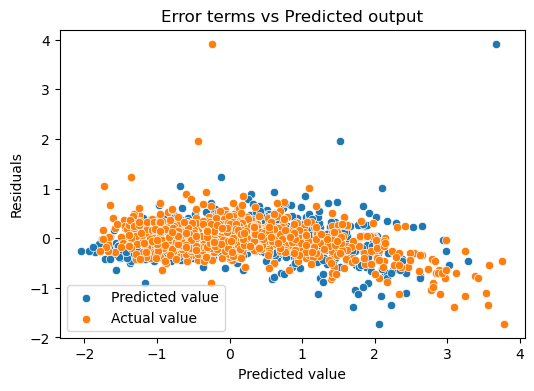

In [113]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_train_pred_lasso.flatten(),y=y_train_pred_lasso.flatten()-y_train.flatten(), label='Predicted value')
sns.scatterplot(x=y_train.flatten(),y=y_train_pred_lasso.flatten()-y_train.flatten(),label='Actual value')
plt.xlabel('Predicted value')
plt.ylabel('Residuals')
plt.title('Error terms vs Predicted output')
plt.show()

### Ridge Regularization

In [114]:
ridge = Ridge()
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,10.0,20.0,50,100,500,1000 ]}
folds=5

# cross validation
ridge_model_cv = GridSearchCV(estimator = ridge, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True,verbose = 1)            
ridge_model_cv.fit(X_train_rfe, y_train) 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 10.0, 20.0, 50, 100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [115]:
ridge_cv_result = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_result[['params','std_train_score','mean_train_score','mean_test_score']]

params  std_train_score  mean_train_score  mean_test_score
0   {'alpha': 0.0001}         0.010484          0.906447         0.840758
1    {'alpha': 0.001}         0.010484          0.906447         0.840771
2     {'alpha': 0.01}         0.010484          0.906446         0.840897
3     {'alpha': 0.05}         0.010487          0.906420         0.841366
4      {'alpha': 0.1}         0.010497          0.906359         0.841831
5      {'alpha': 0.2}         0.010529          0.906197         0.842562
6      {'alpha': 0.3}         0.010567          0.906014         0.843138
7      {'alpha': 0.4}         0.010605          0.905826         0.843616
8      {'alpha': 0.5}         0.010642          0.905638         0.844023
9      {'alpha': 0.6}         0.010677          0.905452         0.844375
10     {'alpha': 0.7}         0.010711          0.905270         0.844684
11     {'alpha': 0.8}         0.010744          0.905090         0.844957
12     {'alpha': 0.9}         0.010775          0.904913         0.845200
13     {'alpha': 1.0}         0.010805          0.904740         0.845418
14     {'alpha': 2.0}         0.011072          0.903132         0.846706
15     {'alpha': 3.0}         0.011302          0.901683         0.847151
16     {'alpha': 4.0}         0.011510          0.900344         0.847218
17     {'alpha': 5.0}         0.011700          0.899096         0.847091
18    {'alpha': 10.0}         0.012456          0.893846         0.845545
19    {'alpha': 20.0}         0.013425          0.886274         0.842286
20      {'alpha': 50}         0.014725          0.872789         0.836068
21     {'alpha': 100}         0.015383          0.860364         0.830316
22     {'alpha': 500}         0.015141          0.819783         0.805026
23    {'alpha': 1000}         0.014222          0.786169         0.775729

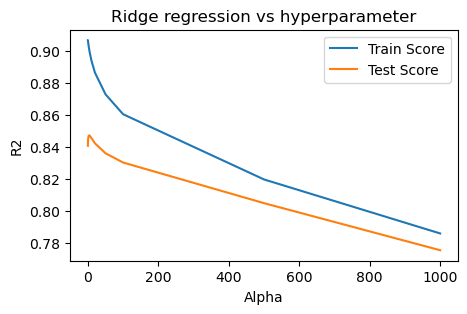

In [116]:
rvalues = [d['alpha'] for d in ridge_cv_result['params'].values]
ridge_cv_result['param_alpha'] = ridge_cv_result['param_alpha'].astype('int32')
plt.figure(figsize=(5,3))
plt.plot(rvalues, ridge_cv_result['mean_train_score'], label='Train Score')
plt.plot(rvalues, ridge_cv_result['mean_test_score'],label='Test Score')
plt.xlabel('Alpha')
plt.ylabel('R2')
plt.title('Ridge regression vs hyperparameter')
plt.legend()
plt.show()

In [117]:
ridge_model_cv.best_params_

{'alpha': 4.0}

In [118]:
alpha = 4
ridge = Ridge(alpha=alpha)
ridge.fit(X_train_rfe,y_train)

Ridge(alpha=4)

In [119]:
#Ridge Coefficients
MainRidgeCoeff = pd.Series(ridge.coef_[0],index=ridge.feature_names_in_)
MainRidgeCoeff.sort_values(ascending=False)

Neighborhood_NoRidge     0.469268
Neighborhood_NridgHt     0.404381
Neighborhood_StoneBr     0.325518
SaleCondition_Partial    0.296420
LandContour_HLS          0.290907
                           ...   
KitchenAbvGr            -0.184115
Exterior1st_Stucco      -0.213159
MSSubClass_160          -0.245007
MSSubClass_120          -0.296832
LotShape_IR3            -0.390976
Length: 115, dtype: float64

In [120]:
metric_ridge=[]
y_train_pred_ridge = ridge.predict(X_train_rfe)
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
rss_train_ridge = np.sum(np.square(y_train - y_train_pred_ridge))
mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)
print('Ridge Train Model r2:',r2_train_ridge)

y_test_pred_ridge = ridge.predict(X_test[X_train_rfe.columns])
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)
rss_test_ridge = np.sum(np.square(y_test - y_test_pred_ridge))
mse_test_ridge = mean_squared_error(y_test, y_test_pred_ridge)
print('Ridge Test dataset r2:',r2_test_ridge)

metric_ridge.append(ridge_model_cv.best_params_)
metric_ridge.append(r2_train_ridge)
metric_ridge.append(r2_test_ridge)
metric_ridge.append(rss_train_ridge)
metric_ridge.append(rss_test_ridge)
metric_ridge.append(mse_train_ridge)
metric_ridge.append(mse_test_ridge)


Ridge Train Model r2: 0.8967672361860246
Ridge Test dataset r2: 0.8391435866954426


### Ridge Model Evaluation

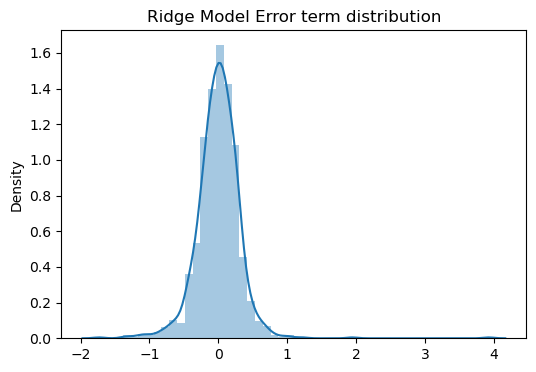

In [121]:
plt.figure(figsize=(6,4))
sns.distplot(y_train_pred_ridge-y_train)
plt.title('Ridge Model Error term distribution')
plt.show()

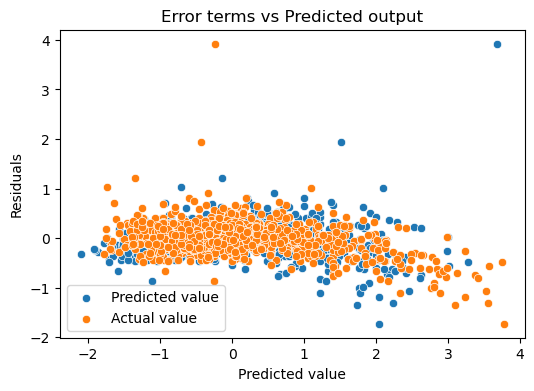

In [122]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_train_pred_ridge.flatten(),y=y_train_pred_ridge.flatten()-y_train.flatten(),label='Predicted value')
sns.scatterplot(x=y_train.flatten(),y=y_train_pred_ridge.flatten()-y_train.flatten(),label='Actual value')
plt.xlabel('Predicted value')
plt.ylabel('Residuals')
plt.title('Error terms vs Predicted output')
plt.show()

In [123]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['HyperParameter','R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)','MSE (Train)','MSE (Test)'], 'RFERegression': metric}
#lr_table = {'Metric': ['HyperParameter','R2 Score (Train)','R2 Score (Test)'], 'RFE Regression': metric}

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'RFERegression'] )

rg_metric = pd.Series(metric_ridge, name = 'Ridge Regression')
ls_metric = pd.Series(metric_lasso, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

Metric  RFERegression Ridge Regression  Lasso Regression
0    HyperParameter   1.150000e+02   {'alpha': 4.0}  {'alpha': 0.001}
1  R2 Score (Train)   9.001997e-01         0.896767          0.893996
2   R2 Score (Test)  -2.903453e+16         0.839144          0.839395
3       RSS (Train)   1.008981e+02       104.368324     1917825.37617
4        RSS (Test)   1.247702e+19        69.124883     354570.671243
5       MSE (Train)   9.980033e-02         0.103233          0.106004
6        MSE (Test)   2.874889e+16         0.159274          0.159025

Train and Test score of Ridge and Lasso model seems to be more or less same. Further, Lasso model has penalized 46 features to ZERO. Only 69 features are used to build the model. So, choosing `Lasso Regularization model`. 

In [124]:
#Total features used by Lasso Model
len(MainLassoCoeff[MainLassoCoeff!=0])

69

# Assignement -2 Subjective Questions

### 1. Using the double the value of alpha to check the model behavior

__Double the alpha value for LASSO RIGRESSION__

In [125]:
#Lasso alpha value is 0.001 and now 0.002
alpha = 0.002
assignlasso = Lasso(alpha=alpha)
assignlasso.fit(X_train_rfe,y_train)

Lasso(alpha=0.002)

In [126]:
# Checking r2 for train and test data set
print("#"*70)
y_train_pred_lasso_assign = assignlasso.predict(X_train_rfe)
r2_train_lasso_assign = r2_score(y_train, y_train_pred_lasso_assign)
print('Lasso Train Model r2 value post doubling alpha:',r2_train_lasso_assign)

y_test_pred_lasso_assign = lasso.predict(X_test_rfe)
r2_test_lasso_assign = r2_score(y_test, y_test_pred_lasso_assign)
print('Lasso Test Set r2 value post doubling alpha:',r2_test_lasso_assign)

print("-"*70)
print('Lasso Train Set r2 value pre doubling alpha:',r2_train_lasso)
print('Lasso Test Set r2 value pre doubling alpha:',r2_test_lasso)
print("#"*70)

######################################################################
Lasso Train Model r2 value post doubling alpha: 0.8884414964885949
Lasso Test Set r2 value post doubling alpha: 0.8393946241843337
----------------------------------------------------------------------
Lasso Train Set r2 value pre doubling alpha: 0.8939960156755192
Lasso Test Set r2 value pre doubling alpha: 0.8393946241843337
######################################################################


In [127]:
#Top Import predictor variables post doubling the alpha value: 
assignlassoCoeff = pd.Series(assignlasso.coef_,index=assignlasso.feature_names_in_)
abs(assignlassoCoeff[assignlassoCoeff !=0]).sort_values(ascending=False)[0:5]

Neighborhood_NoRidge     0.444801
Neighborhood_NridgHt     0.375479
LotShape_IR3             0.326919
SaleCondition_Partial    0.278100
2ndFlrSF                 0.273035
dtype: float64

LotShape, Neighborhood, SaleType seems to be important feature variable

__Double the alpha value for RIDGE RIGRESSION__

In [128]:
print("#"*70)
alpha = 8
assignridge = Ridge(alpha=alpha)
assignridge.fit(X_train_rfe,y_train)

# Checking r2 for train and test data set
y_train_pred_ridge_assign = assignridge.predict(X_train_rfe)
r2_train_ridge_assign = r2_score(y_train, y_train_pred_ridge_assign)
print('Ridge Train Model r2 post doubling alpha:',r2_train_ridge_assign)

y_test_pred_ridge_assign = assignridge.predict(X_test_rfe)
r2_test_ridge_assign = r2_score(y_test, y_test_pred_ridge_assign)
print('Ridge Test dataset r2 post doubling alpha:',r2_test_ridge_assign)


print("-"*70)
print('Ridge Train Set r2 value pre doubling alpha:',r2_train_ridge)
print('Ridge Test Set r2 value pre doubling alpha:',r2_test_ridge)
print("#"*70)

######################################################################
Ridge Train Model r2 post doubling alpha: 0.8929831746760066
Ridge Test dataset r2 post doubling alpha: 0.8386526122908717
----------------------------------------------------------------------
Ridge Train Set r2 value pre doubling alpha: 0.8967672361860246
Ridge Test Set r2 value pre doubling alpha: 0.8391435866954426
######################################################################


In [129]:
#Top Import predictor variables post doubling the alpha value: 
assignRidgeCoeff = pd.Series(assignridge.coef_[0],index=assignridge.feature_names_in_)
abs(assignRidgeCoeff).sort_values(ascending=False)[0:5]

Neighborhood_NoRidge     0.392869
Neighborhood_NridgHt     0.342815
LotShape_IR3             0.286196
SaleCondition_Partial    0.266860
1stFlrSF                 0.258899
dtype: float64

### 3. Model build removing 5 most important variable.

In [130]:
#Total no of feature used to train Lasso Model
len(MainLassoCoeff[MainLassoCoeff!=0])

69

In [131]:
NoZeroMainLassoCoeff = MainLassoCoeff[MainLassoCoeff !=0]
abs(NoZeroMainLassoCoeff).sort_values(ascending=False)[0:20]

Neighborhood_NoRidge     0.508991
LotShape_IR3             0.468144
Neighborhood_NridgHt     0.425812
Neighborhood_StoneBr     0.346527
MSSubClass_120           0.298645
SaleCondition_Partial    0.297312
Neighborhood_Crawfor     0.281472
2ndFlrSF                 0.273122
LandContour_HLS          0.269012
1stFlrSF                 0.264240
MSSubClass_160           0.233599
KitchenAbvGr             0.212483
Exterior1st_CemntBd      0.211834
Neighborhood_Veenker     0.211581
HouseStyle_1Story        0.208987
Exterior1st_BrkFace      0.201896
Neighborhood_ClearCr     0.198999
Neighborhood_Somerst     0.192901
Exterior1st_Stucco       0.180498
GarageCars               0.180043
dtype: float64

In [132]:
#Since we encoded the features, I have considered the original features based on the top features taken from LASSO model.
#Following are the top 5 features needs to be dropped from the orginal dataset.

#Neighborhood, LotShape, MSSubClass, SaleCondition,2ndFlrSF


topFiveDropHouseNominal = houseNominal.drop(['Neighborhood','LotShape','MSSubClass','SaleCondition'],axis=1)
topFiveDropHouseCont=houseCont.drop(['2ndFlrSF'],axis=1)
topFiveDropHouseNominal_ec = pd.get_dummies(topFiveDropHouseNominal,drop_first=True,dtype=int)

dropFiveHouseFinal = pd.concat([houseCatOrdinal_ec,houseNumOrdinal,topFiveDropHouseNominal_ec,topFiveDropHouseCont],axis=1)
dropFiveHouseFinal.shape

(1445, 117)

In [133]:
dropFivey = dropFiveHouseFinal.pop('SalePrice')
dropFiveX = dropFiveHouseFinal

dropFX_train, dropFX_test, dropFy_train, dropFy_test = train_test_split(dropFiveX,dropFivey,train_size=0.7,test_size=0.3,random_state=100)

In [134]:
dropFX_train
dropFy_train

#Scaling removed the column, so reassigning them
scaler_dropX = StandardScaler()
scaler_dropy = StandardScaler()

dcol = topFiveDropHouseCont.drop(['SalePrice'],axis=1)
dcol = dcol.columns


#X_train[sch.columns] = scaler_X.fit_transform(X_train[sch.columns])
dropFX_train[dcol] = scaler_dropX.fit_transform(dropFX_train[dcol])
dropFy_train = scaler_dropy.fit_transform(dropFy_train.values.reshape(-1,1))

In [135]:
#dropFX_train_sm = sm.add_constant(dropFX_train)
#droplr_model = sm.OLS(dropFy_train,dropFX_train_sm).fit()
#print(droplr_model.summary())

In [136]:
aslasso = Lasso()
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0 ]}
folds=5

# cross validation
assignmodel_cv = GridSearchCV(estimator = aslasso, param_grid = params, scoring= 'r2', cv = folds, return_train_score=True,verbose = 1)            
assignmodel_cv.fit(dropFX_train, dropFy_train) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [137]:
assignmodel_cv.best_params_

{'alpha': 0.001}

In [138]:
alpha = 0.001
aslasso = Lasso(alpha=alpha)
aslasso.fit(dropFX_train,dropFy_train)

Lasso(alpha=0.001)

In [139]:
TestMainLassoCoeff = pd.Series(aslasso.coef_,index=aslasso.feature_names_in_)
abs(TestMainLassoCoeff[TestMainLassoCoeff !=0]).sort_values(ascending=False)[0:5]

BldgType_Twnhs         0.365036
LandContour_HLS        0.291586
Exterior1st_BrkFace    0.253861
GarageType_BuiltIn     0.251272
HouseStyle_SLvl        0.244918
dtype: float64

In [140]:
len(TestMainLassoCoeff[TestMainLassoCoeff !=0])

77